c:\Users\rfeng6\.conda\envs\TFNN\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


(3089.8894819252682+0j)


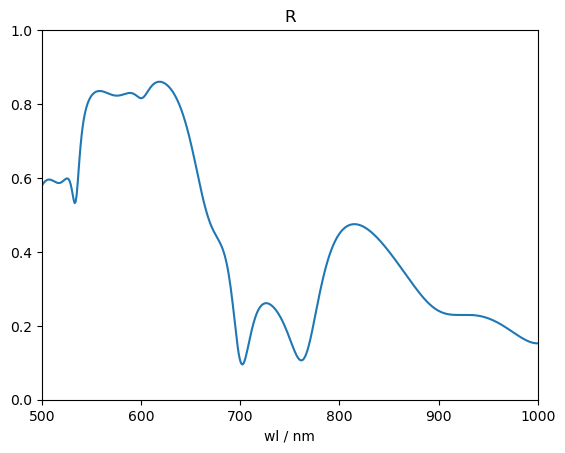

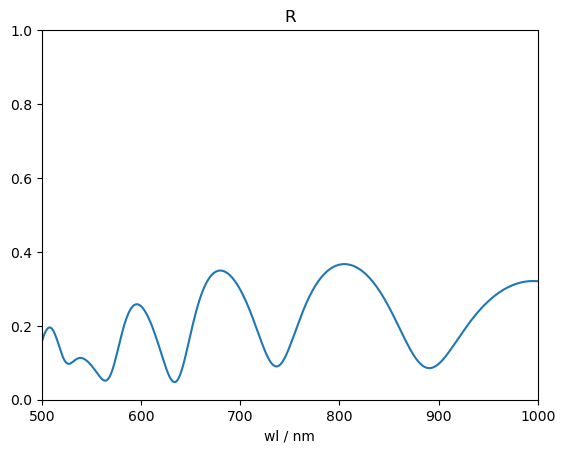

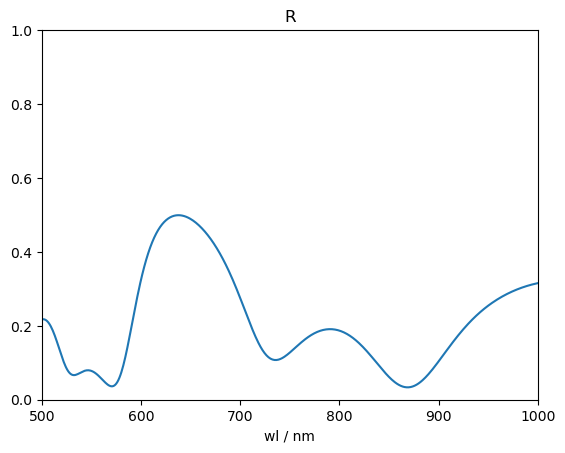

In [1]:
import sys
sys.path.append('./../../designer/script/')
import os
from gets.get_spectrum import get_spectrum_simple
from design import DesignSimple
from film import FilmSimple
from spectrum import SpectrumSimple
from utils.plot_spectrum import plot_spectrum
from utils.load_designs import load_designs_single_spec, init_film_single_spec
from utils.sort import sort_by_ith_list
import numpy as np
import copy
from utils.loss import calculate_RMS
import matplotlib.pyplot as plt

# Initialize: config for TML
WLS = np.linspace(500, 1000, 500)
INC_ANG = 60.
wl = 750. # wl used for calculating OT

def plot_film(f: FilmSimple):
    f.add_spec_param(INC_ANG, WLS)
    spec_target = f.get_spec()
    spec_target.calculate() # compile cuda kernel func
    plot_spectrum(spec_target)

np.random.seed(1)
f_target_30layers = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(30) * 100) # target film
plot_film(f_target_30layers)

np.random.seed(1)
f_target_4layers = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(4) * 750) # target film
plot_film(f_target_4layers)

np.random.seed(1)
f_target_8layers = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(8) * 3000 / 8) # target film
init_film_single_spec(f_target_8layers, INC_ANG, WLS)

np.random.seed(3)
f_target_3layers_seed3 = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(3) * 3000 / 3) # target film
init_film_single_spec(f_target_3layers_seed3, INC_ANG, WLS)
print(f_target_3layers_seed3.get_optical_thickness(750))

np.random.seed(2)
f_target_4layers_seed2 = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(4) * 3000 / 4) # target film
plot_film(f_target_4layers_seed2)


np.random.seed(3)
f_target_5layers_seed3 = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(5) * 3000 / 5) # target film
init_film_single_spec(f_target_5layers_seed3, INC_ANG, WLS)


In [2]:
# Load trained films data and construct Design objects
runs_dict = {
            "SiO2_30layers": {},
            "TiO2_30layers": {},
            "SiO2_4layers": {},
            "TiO2_4layers": {}, 
            "SiO2_8layers": {},
            "TiO2_8layers": {},
            "SiO2_3layers_seed3": {},
            "SiO2_4layers_seed2": {},
            "SiO2_5layers_seed3": {},
            }
runs_dict['SiO2_30layers']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_SiO2_target30layers/'
runs_dict['TiO2_30layers']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_TiO2_target30layers/'
runs_dict['SiO2_4layers']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/'
runs_dict['TiO2_4layers']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_TiO2_target4layers/'
runs_dict['SiO2_8layers']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_SiO2_target8layers/'
runs_dict['TiO2_8layers']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_TiO2_target8layers/'

runs_dict['SiO2_3layers_seed3']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_SiO2_target3layers_seed3/'
runs_dict['SiO2_4layers_seed2']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers_seed2/'
runs_dict['SiO2_5layers_seed3']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_SiO2_target5layers_seed3/'



runs_dict['SiO2_30layers']['save_fig_dir'] = './figs/50iters_0to2OT_200run_SiO2_target30layers/'
runs_dict['TiO2_30layers']['save_fig_dir'] = './figs/50iters_0to2OT_200run_TiO2_target30layers/'
runs_dict['SiO2_4layers']['save_fig_dir'] = './figs/50iters_0to2OT_200run_SiO2_target4layers/'
runs_dict['TiO2_4layers']['save_fig_dir'] = './figs/50iters_0to2OT_200run_TiO2_target4layers/'
runs_dict['SiO2_8layers']['save_fig_dir'] = './figs/50iters_0to2OT_200run_SiO2_target8layers/'
runs_dict['TiO2_8layers']['save_fig_dir'] = './figs/50iters_0to2OT_200run_TiO2_target8layers/'

runs_dict['SiO2_3layers_seed3']['save_fig_dir'] = './figs/50iters_0to2OT_200run_SiO2_target3layers_seed3/'
runs_dict['SiO2_4layers_seed2']['save_fig_dir'] = './figs/50iters_0to2OT_200run_SiO2_target4layers_seed2/'
runs_dict['SiO2_5layers_seed3']['save_fig_dir'] = './figs/50iters_0to2OT_200run_SiO2_target5layers_seed3/'



runs_dict['SiO2_30layers']['designs'] = load_designs_single_spec(runs_dict['SiO2_30layers']['file_dir'], f_target_30layers, n_A='SiO2', n_B='TiO2', n_sub='SiO2')
runs_dict['TiO2_30layers']['designs'] = load_designs_single_spec(runs_dict['TiO2_30layers']['file_dir'], f_target_30layers, n_A='TiO2', n_B='SiO2', n_sub='SiO2')
runs_dict['SiO2_4layers']['designs'] = load_designs_single_spec(runs_dict['SiO2_4layers']['file_dir'], f_target_4layers, n_A='SiO2', n_B='TiO2', n_sub='SiO2')
runs_dict['TiO2_4layers']['designs'] = load_designs_single_spec(runs_dict['TiO2_4layers']['file_dir'], f_target_4layers, n_A='TiO2', n_B='SiO2', n_sub='SiO2')
runs_dict['SiO2_8layers']['designs'] = load_designs_single_spec(runs_dict['SiO2_8layers']['file_dir'], f_target_8layers, n_A='SiO2', n_B='TiO2', n_sub='SiO2')
runs_dict['TiO2_8layers']['designs'] = load_designs_single_spec(runs_dict['TiO2_8layers']['file_dir'], f_target_8layers, n_A='TiO2', n_B='SiO2', n_sub='SiO2')

runs_dict['SiO2_3layers_seed3']['designs'] = load_designs_single_spec(runs_dict['SiO2_3layers_seed3']['file_dir'], f_target_3layers_seed3, n_A='SiO2', n_B='TiO2', n_sub='SiO2')
runs_dict['SiO2_4layers_seed2']['designs'] = load_designs_single_spec(runs_dict['SiO2_4layers_seed2']['file_dir'], f_target_4layers_seed2, n_A='SiO2', n_B='TiO2', n_sub='SiO2')
runs_dict['SiO2_5layers_seed3']['designs'] = load_designs_single_spec(runs_dict['SiO2_5layers_seed3']['file_dir'], f_target_5layers_seed3, n_A='SiO2', n_B='TiO2', n_sub='SiO2')

for key in runs_dict:
    if not os.path.isdir(runs_dict[key]['save_fig_dir']):
        os.makedirs(runs_dict[key]['save_fig_dir'])


Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)


c:\Users\rfeng6\Desktop\working\Thin-Film-Design\working\OT-loss\./../../designer/script\utils\load_designs.py:37: UserWarning: loadtxt: input contained no data: "./../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/run_23/iter_0"
  np.loadtxt(file_dir + f'run_{run_idx}/iter_0', dtype=float)*1000.
c:\Users\rfeng6\Desktop\working\Thin-Film-Design\working\OT-loss\./../../designer/script\utils\load_designs.py:37: UserWarning: loadtxt: input contained no data: "./../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/run_31/iter_0"
  np.loadtxt(file_dir + f'run_{run_idx}/iter_0', dtype=float)*1000.
c:\Users\rfeng6\Desktop\working\Thin-Film-Design\working\OT-loss\./../../designer/script\utils\load_designs.py:37: UserWarning: loadtxt: input contained no data: "./../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/run_32/iter_0"
  np.loadtxt(file_dir + f'run_{run_idx}/iter_0', dtype=float)*1000.
c:\Users\rfeng6\Desktop\working\Thin-Film-Design\working\OT-loss\./../

Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)


c:\Users\rfeng6\.conda\envs\TFNN\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
c:\Users\rfeng6\.conda\envs\TFNN\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rfeng6\.conda\envs\TFNN\lib\site-packages\matplotlib\transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_16216\839871801.py:46: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 0.4) # set lower bound of y to zero


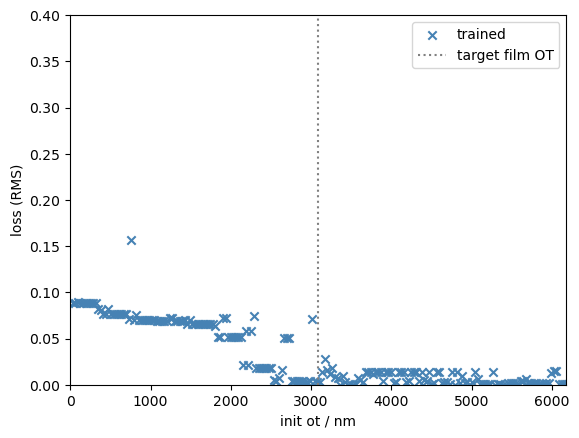

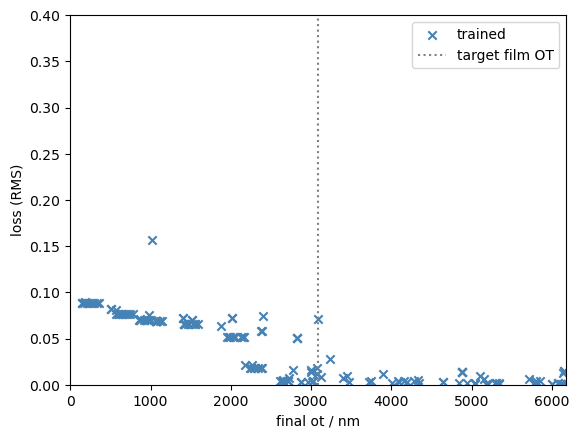

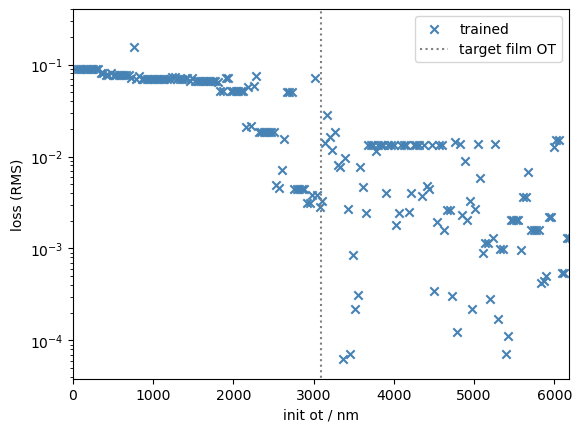

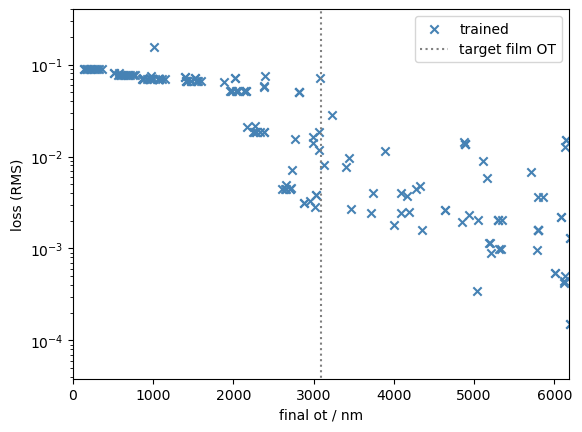

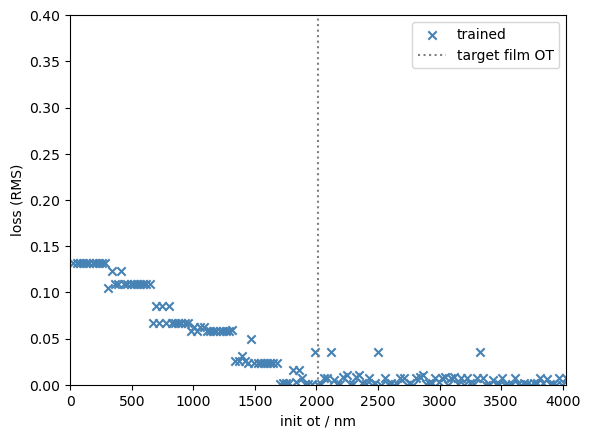

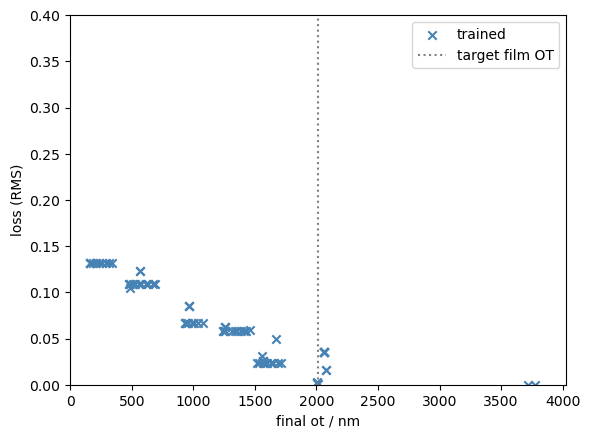

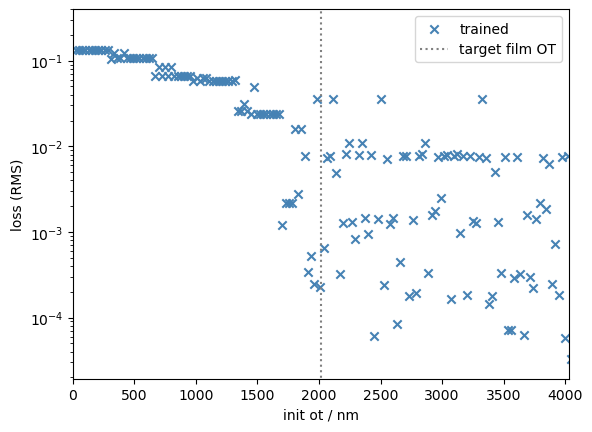

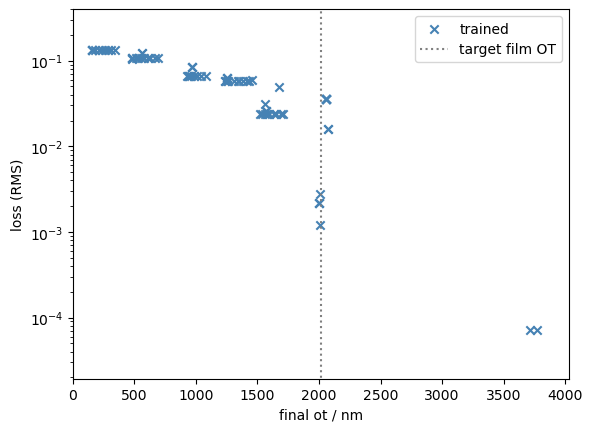

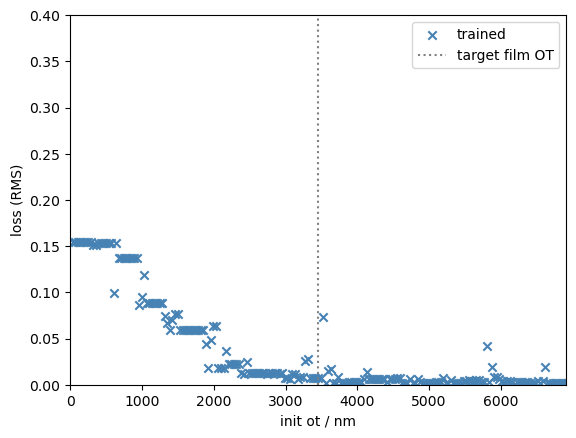

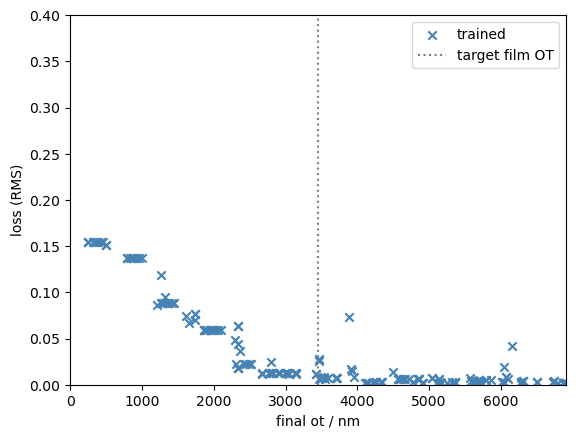

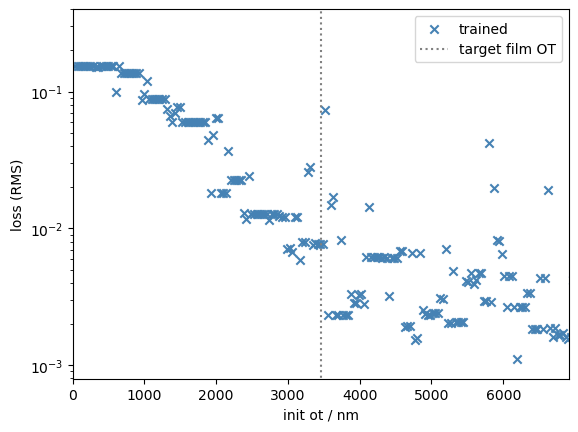

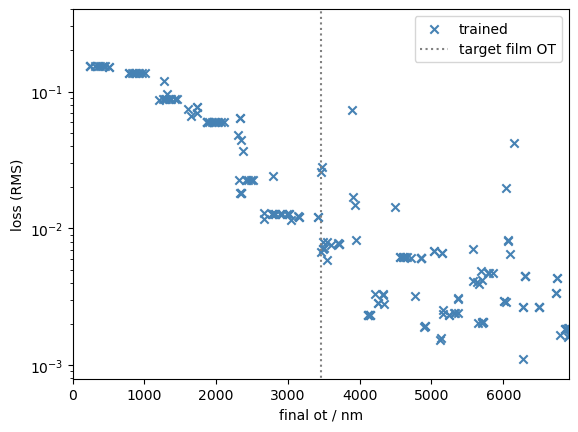

In [3]:
def plot(design_list: list[DesignSimple], x='initial_ot', log=False):
    target_ot = design_list[0].get_target_ot(wl, correct_sub=False)
    target_thickness = design_list[0].get_target_gt()
             
    fig, ax = plt.subplots(1, 1)

    if x == 'initial_ot':
        for design in design_list:
            ax.scatter(design.get_init_ot(wl), design.loss, c='steelblue', marker='x')
        # scatter the first dot for the legend
        ax.scatter(design.get_init_ot(wl), design.loss, c='steelblue', marker='x', label='trained')
        ax.plot([target_ot, target_ot], [0, 1], label='target film OT', c='gray', ls=':')

        ax.set_xlabel('init ot / nm')
        ax.set_xlim(0, target_ot * 2)

    elif x == 'final_ot':
        for design in design_list:
            ax.scatter(design.get_current_ot(wl), design.loss, c='steelblue', marker='x')
        # scatter the first dot for the legend
        ax.scatter(design.get_current_ot(wl), design.loss, c='steelblue', marker='x', label='trained')
        ax.plot([target_ot, target_ot], [0, 1], label='target film OT', c='gray', ls=':')
        
        ax.set_xlabel('final ot / nm')
        ax.set_xlim(0, target_ot * 2)

    elif x == 'initial_gt': # geometrical thickness
        for design in design_list:
            ax.scatter(design.get_init_gt(), design.loss, c='steelblue', marker='x')
        # scatter the first dot for the legend
        ax.scatter(design.get_init_gt(), design.loss, c='steelblue', marker='x', label='trained')
        ax.plot([target_thickness, target_thickness], [0, 1], label='target film GT', c='gray', ls=':')
        
        ax.set_xlabel('init gt / nm')
        ax.set_xlim(0, target_thickness * 3)


    if log:
        log_label = 'log_'
        ax.set_yscale('log')
    else:
        log_label='linear_'

    ax.legend()
    ax.set_ylabel('loss (RMS)')
    ax.set_ylim(0, 0.4) # set lower bound of y to zero

    fig.savefig(runs_dict[run_name]['save_fig_dir'] + f'{log_label}loss-{x}.png', dpi=300)


for run_name in runs_dict:
    if 'seed' not in run_name:
        continue
    fig = plot(runs_dict[run_name]['designs'], 'initial_ot', log=False)
    fig = plot(runs_dict[run_name]['designs'], 'final_ot', log=False)
    fig = plot(runs_dict[run_name]['designs'], 'initial_ot', log=True)
    fig = plot(runs_dict[run_name]['designs'], 'final_ot', log=True)
    # fig = plot(runs_dict[run_name]['designs'], 'wrt init gt').savefig(runs_dict[run_name]['save_fig_dir'] + 'loss-initial_gt.png', dpi=300)
    



C:\Users\rfeng6\AppData\Local\Temp\ipykernel_16216\2697922982.py:77: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 0.4) # set lower bound of y to zero
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_16216\2697922982.py:49: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 0.4) # set lower bound of y to zero
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_16216\2697922982.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


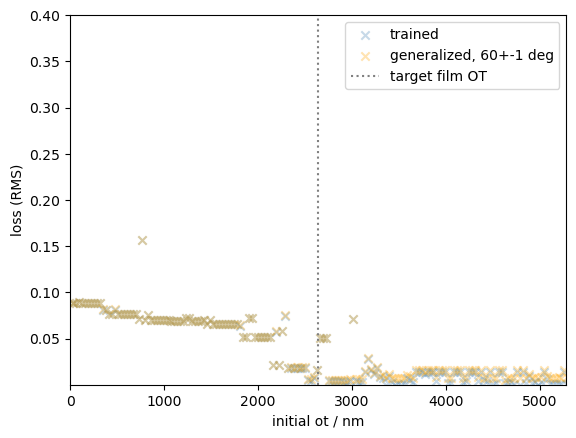

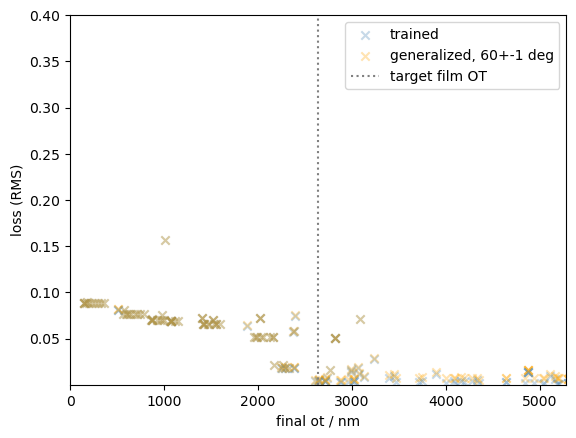

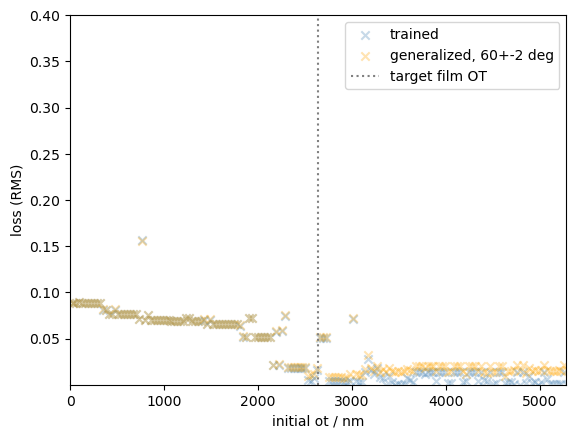

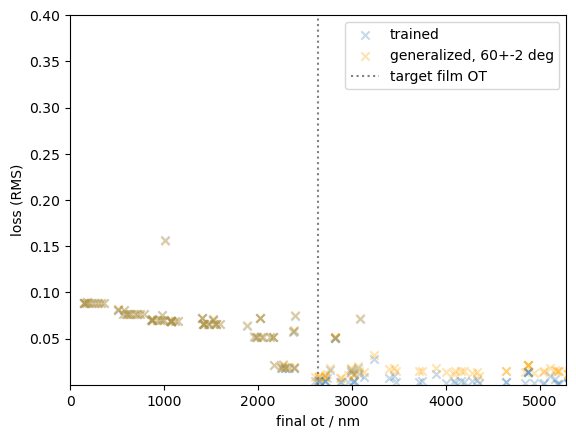

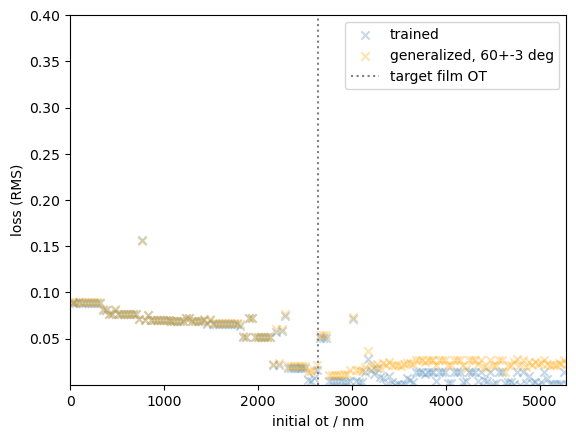

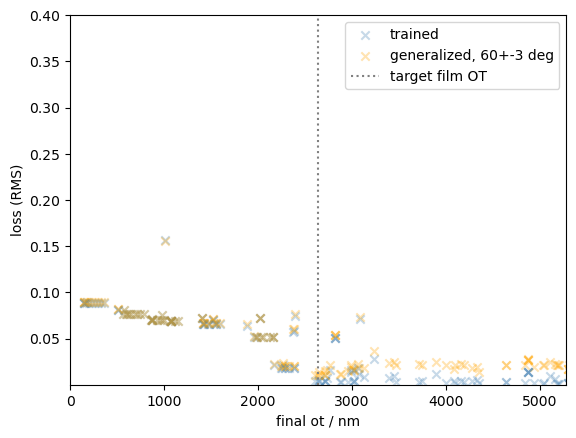

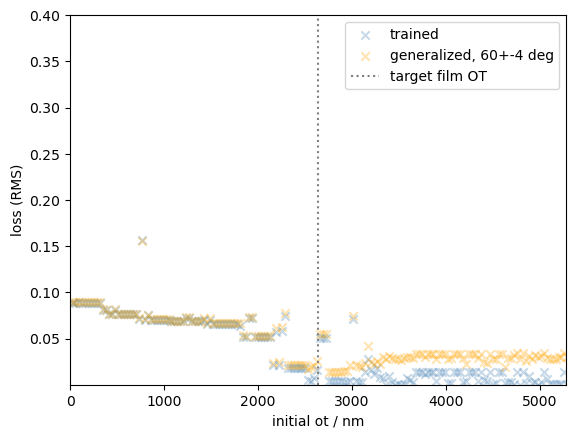

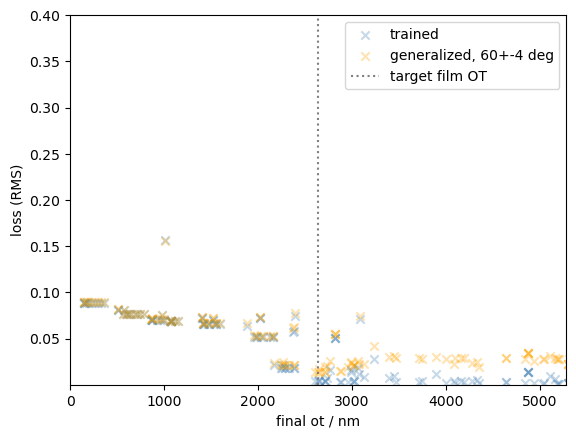

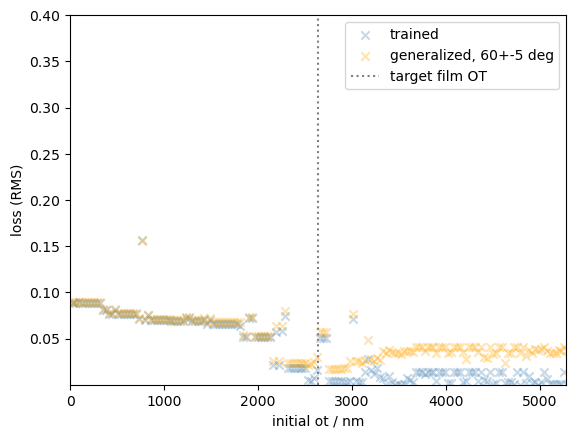

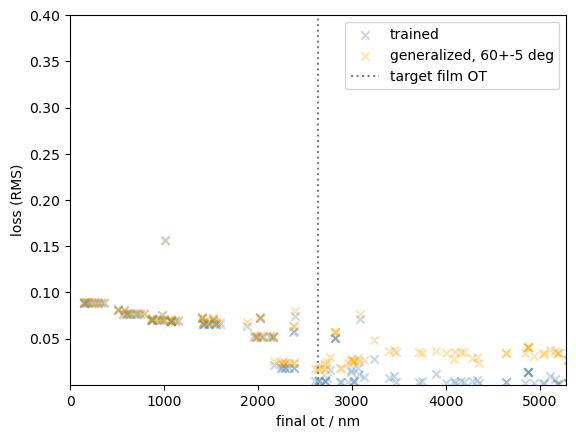

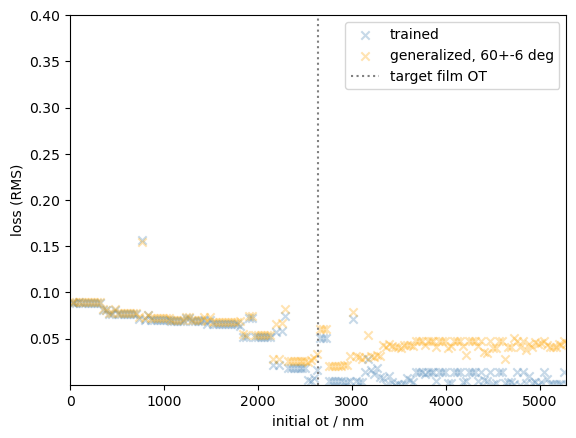

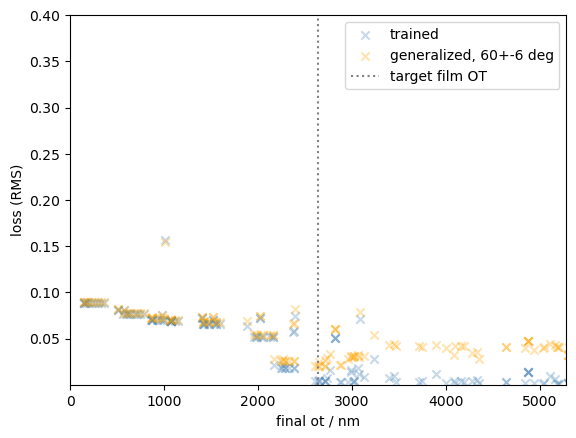

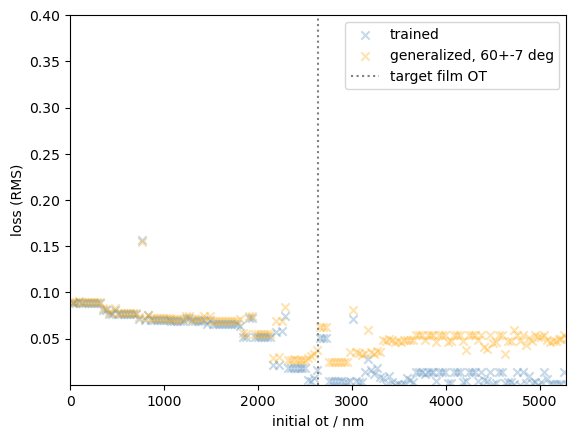

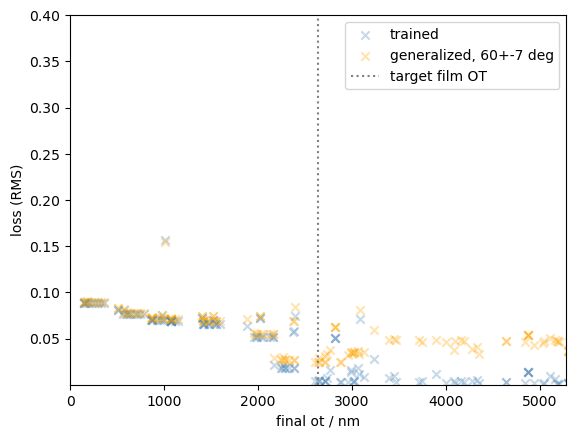

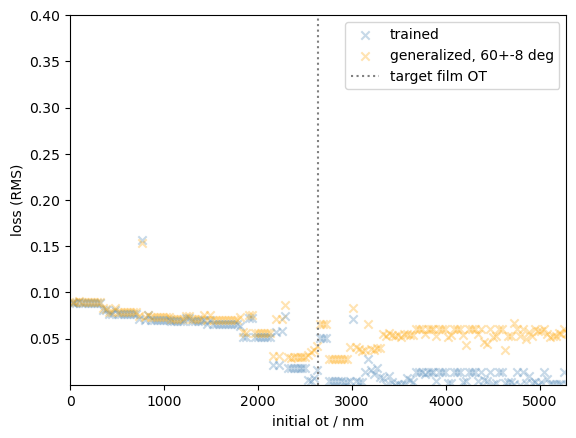

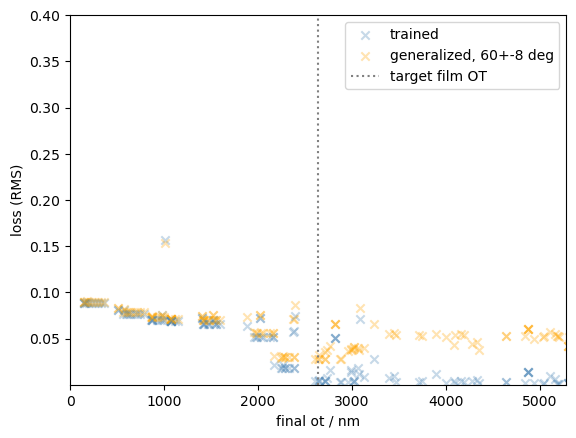

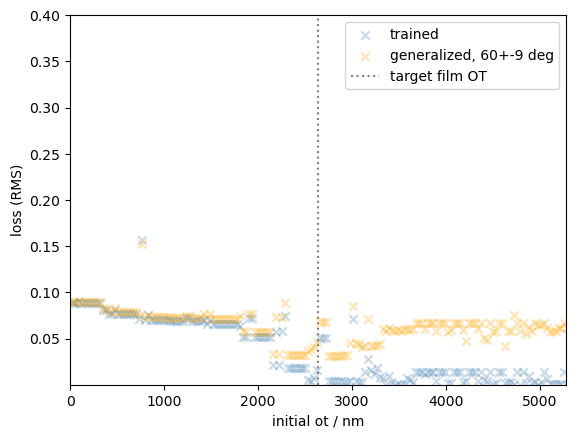

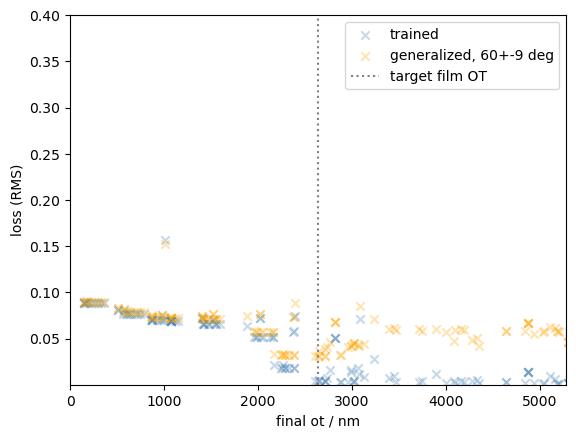

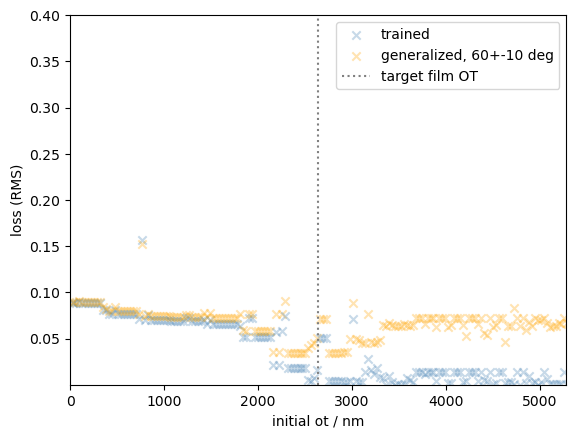

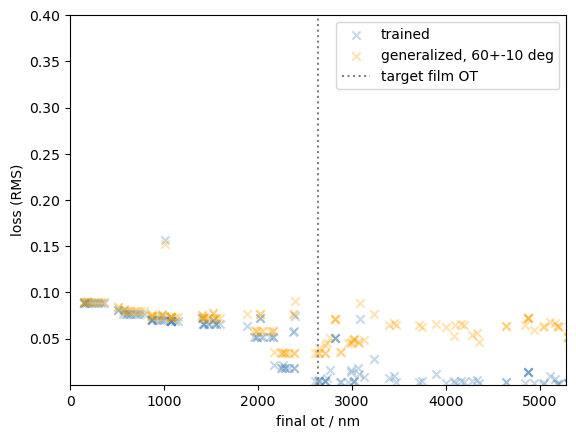

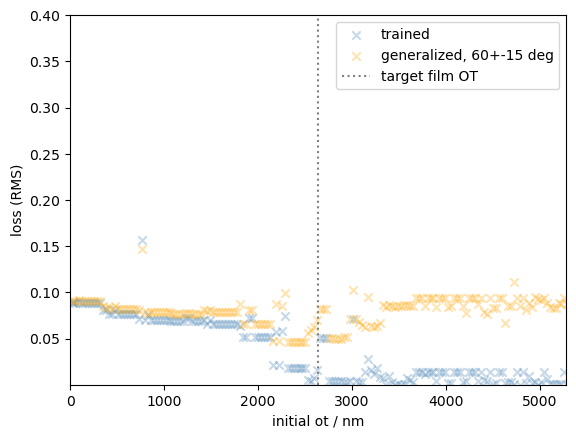

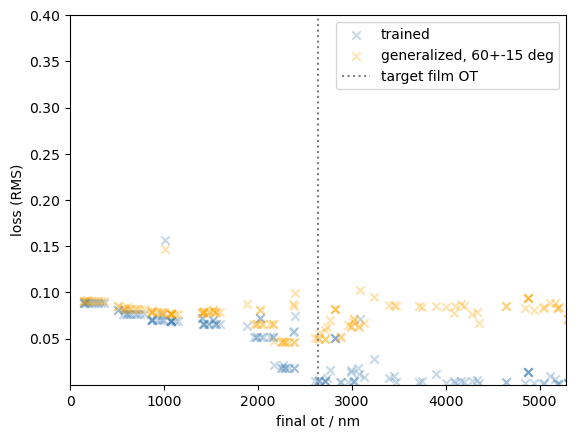

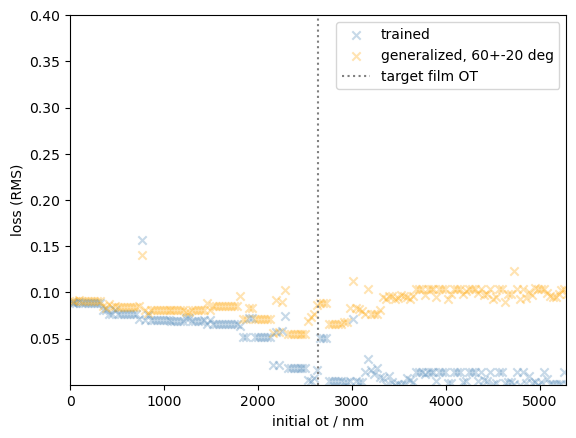

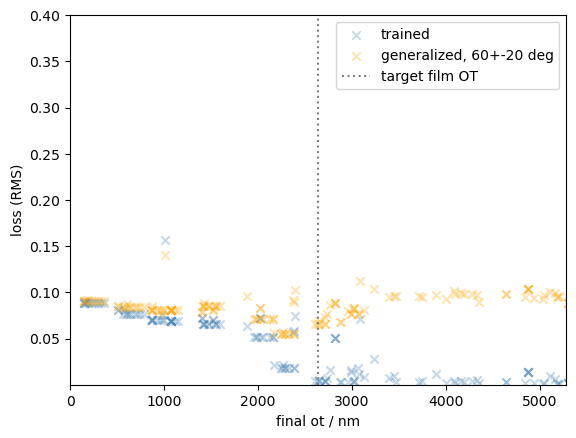

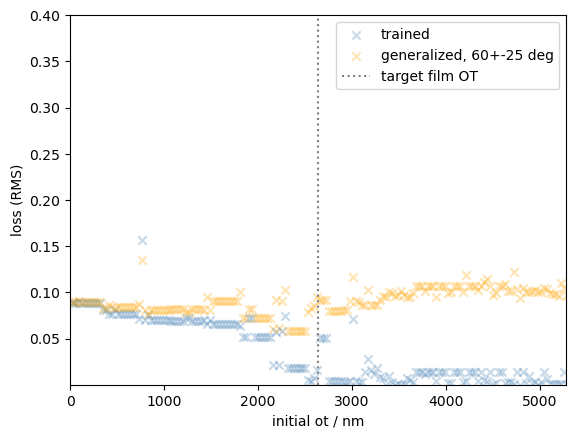

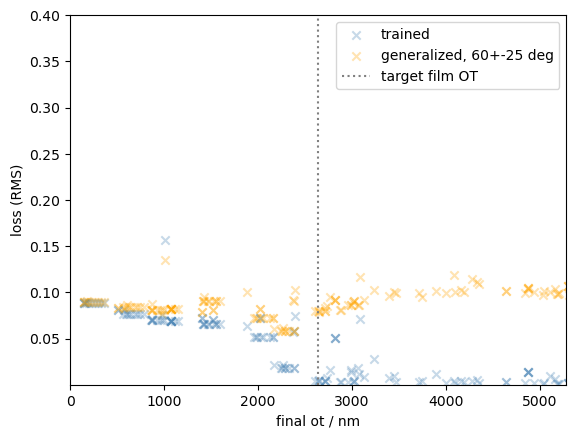

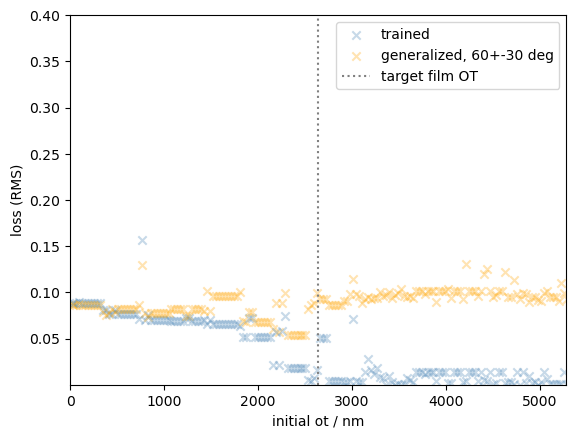

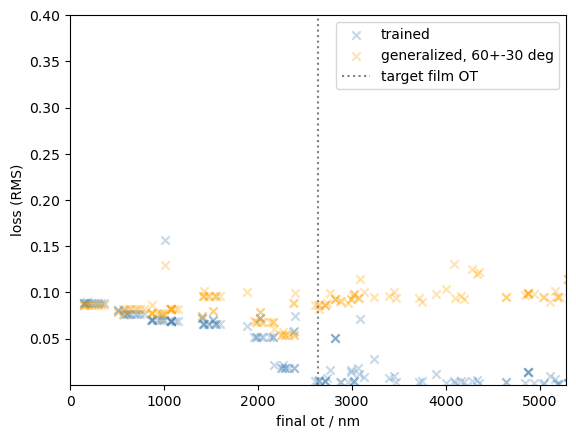

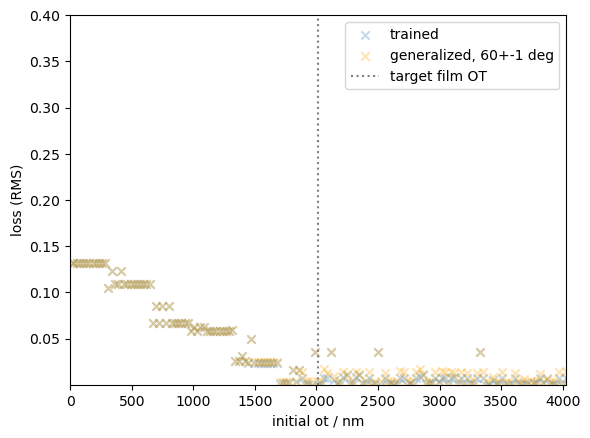

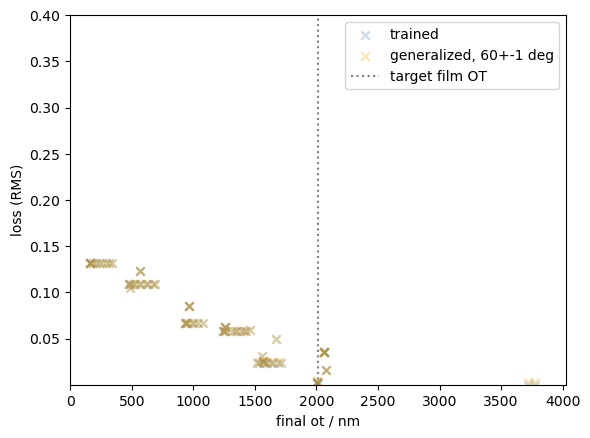

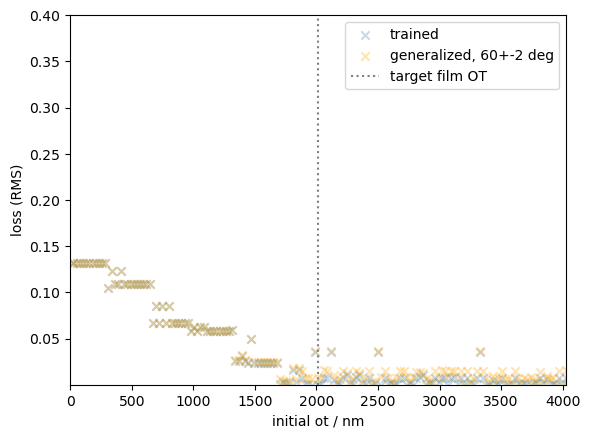

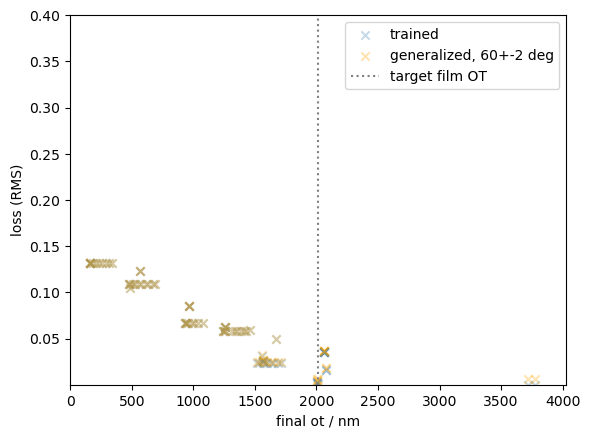

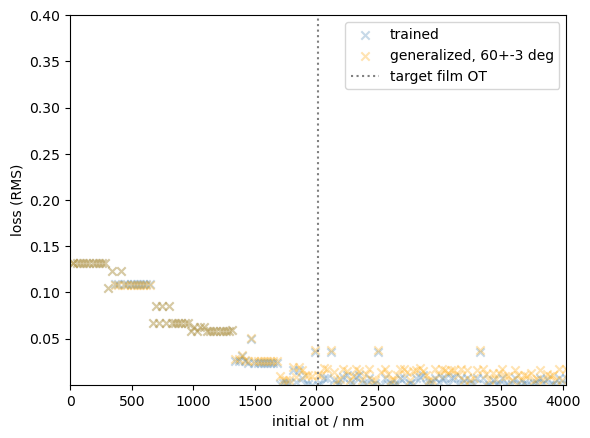

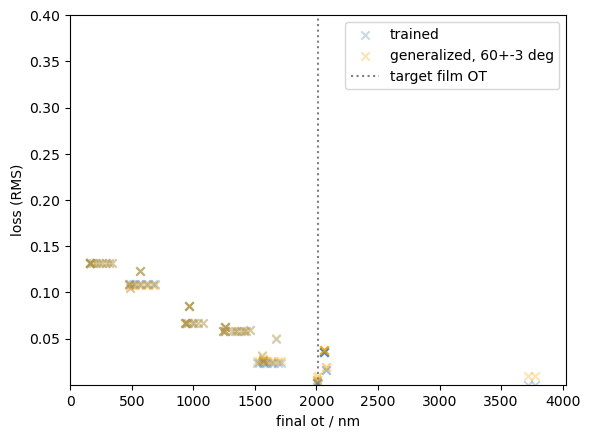

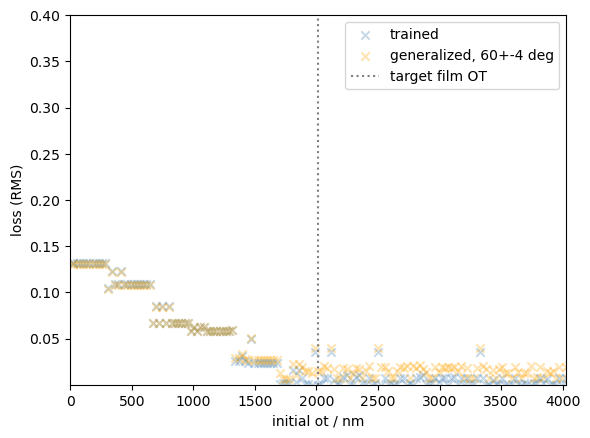

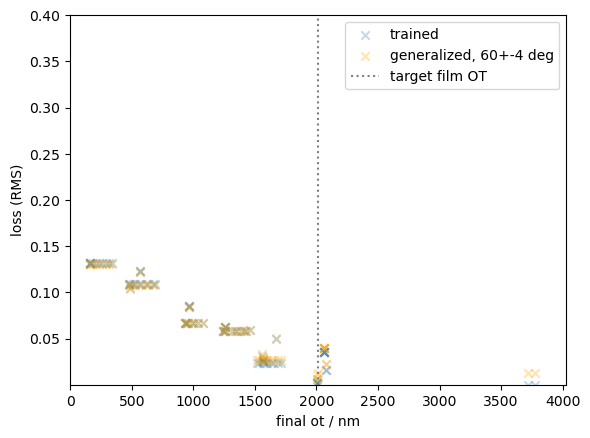

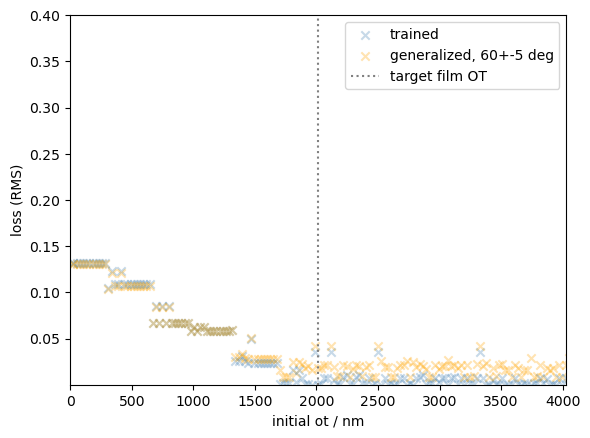

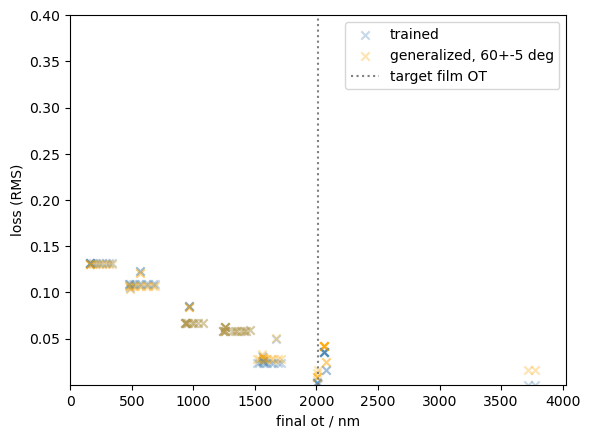

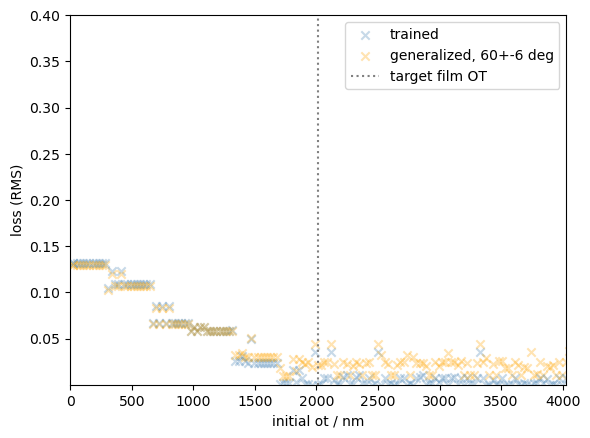

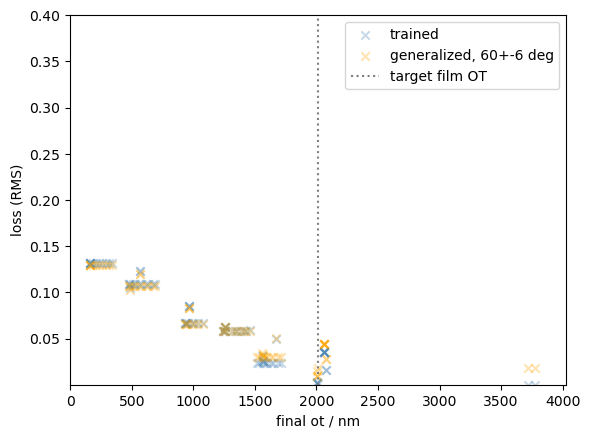

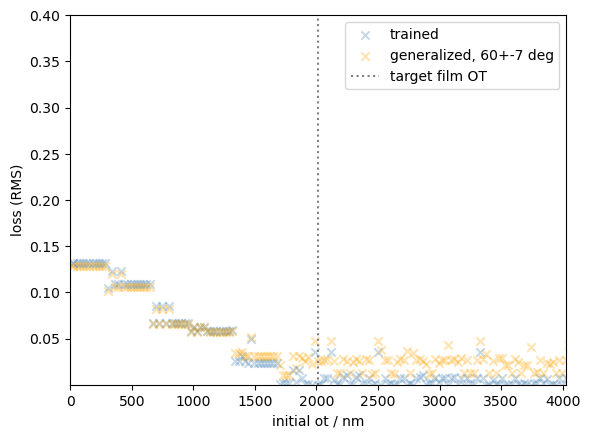

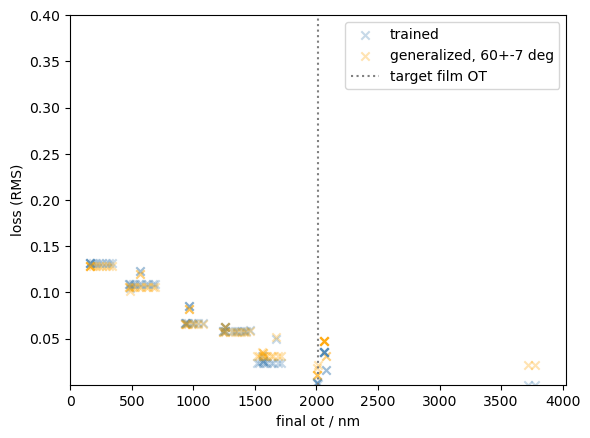

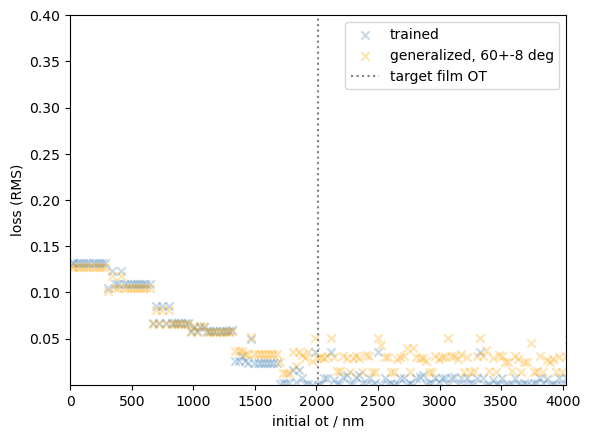

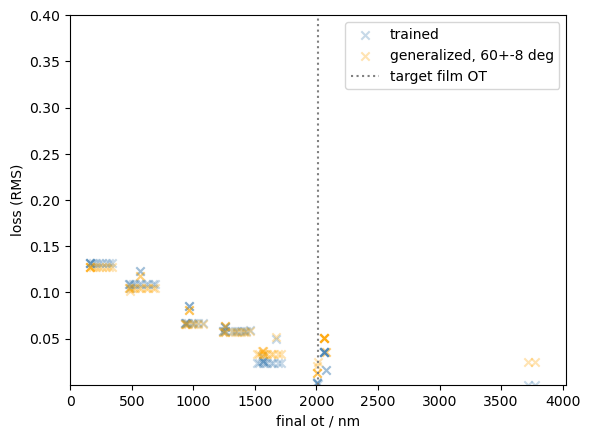

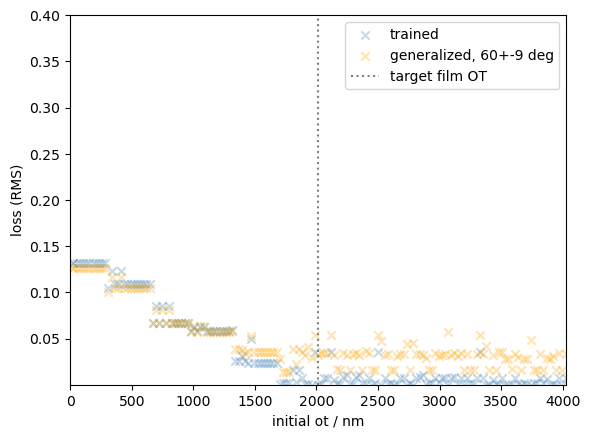

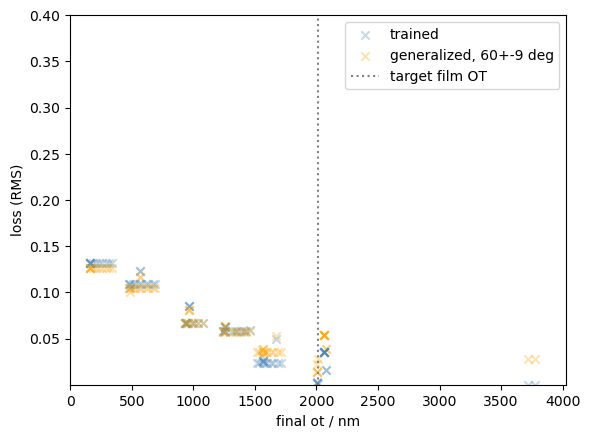

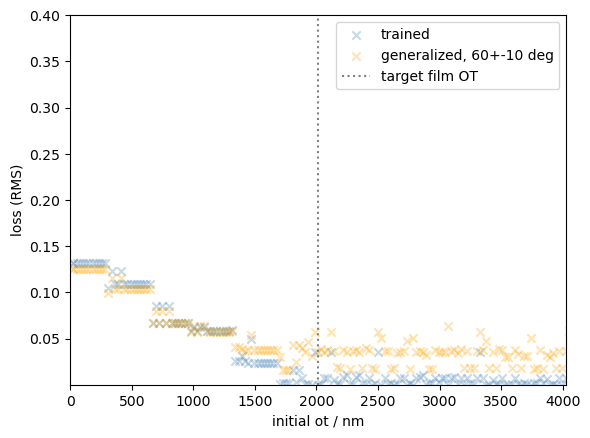

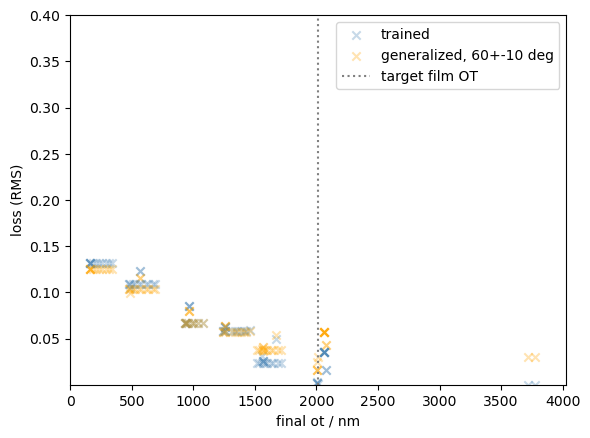

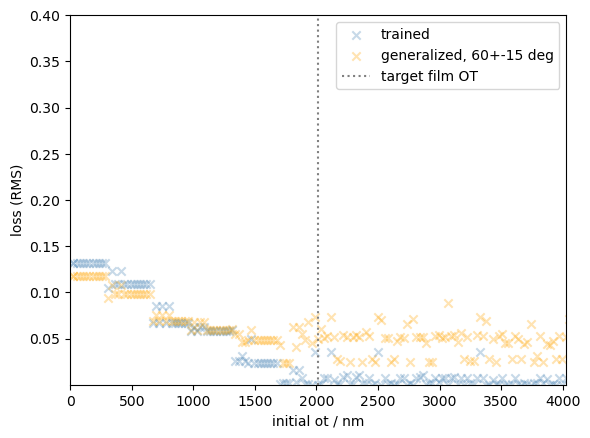

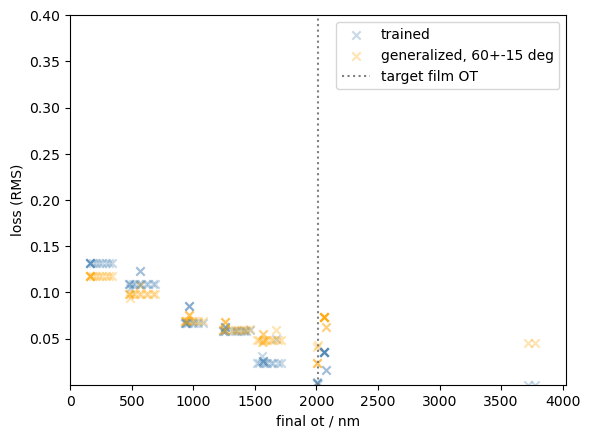

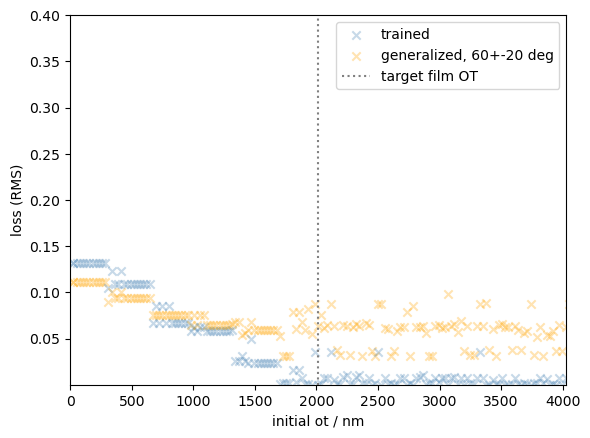

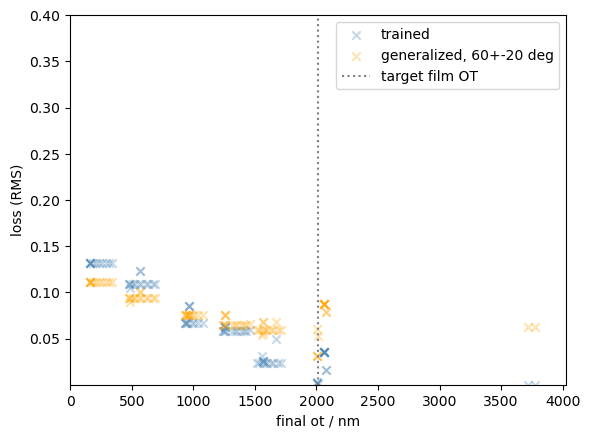

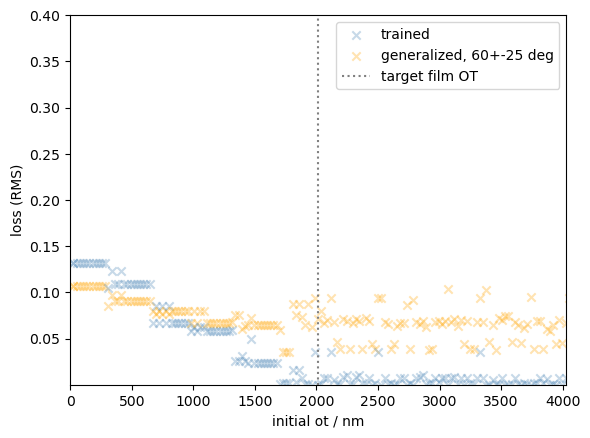

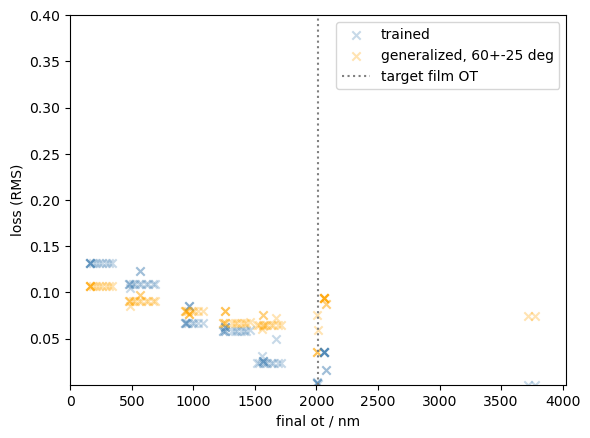

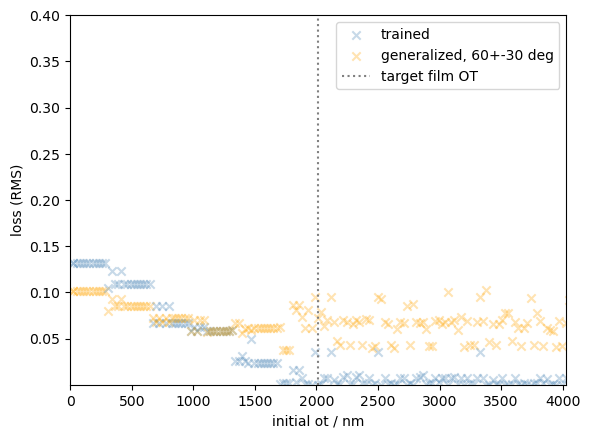

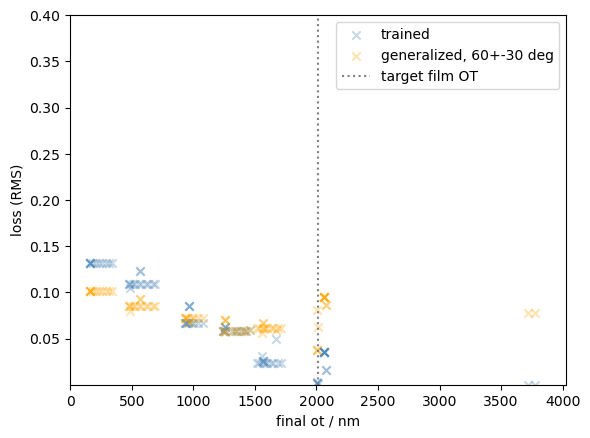

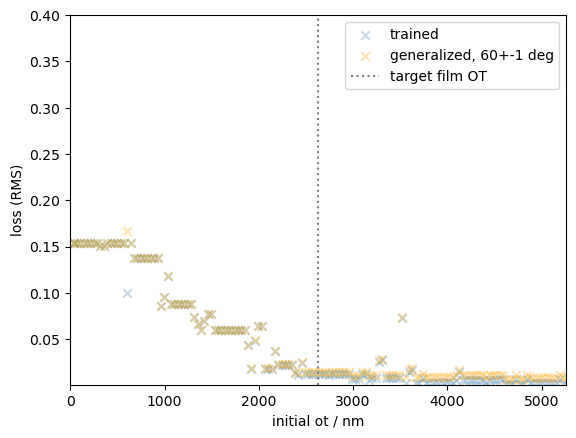

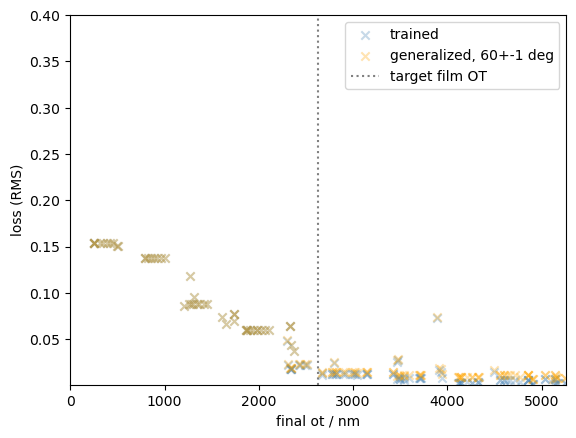

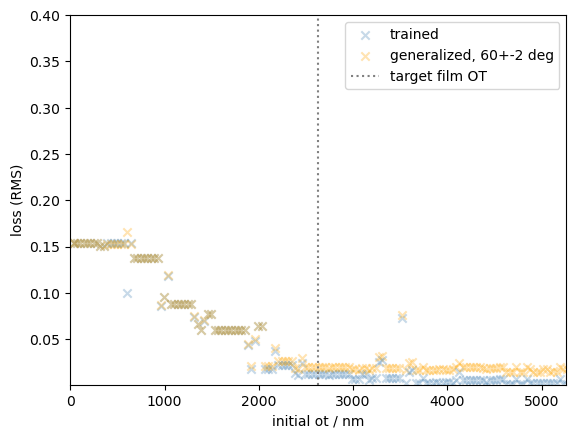

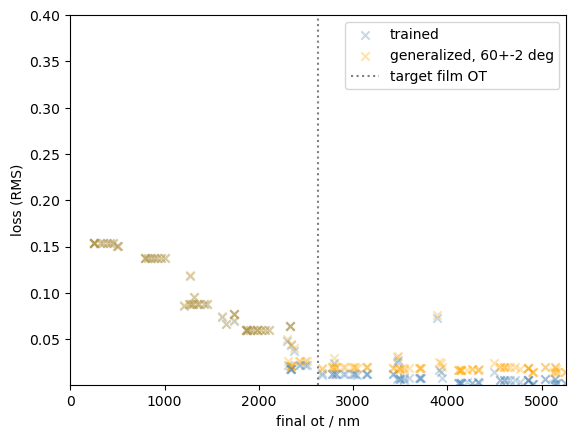

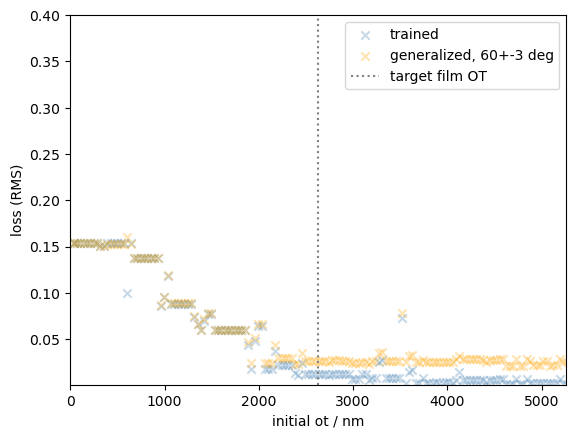

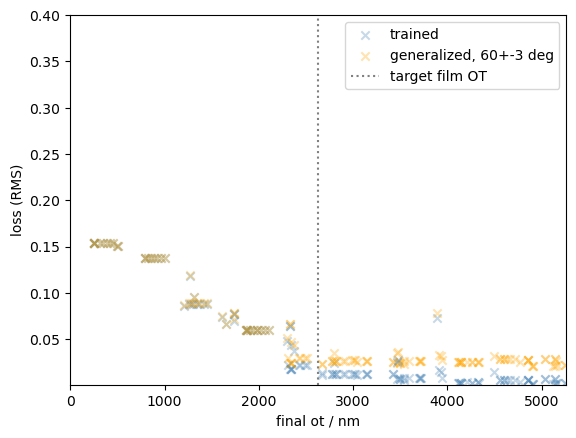

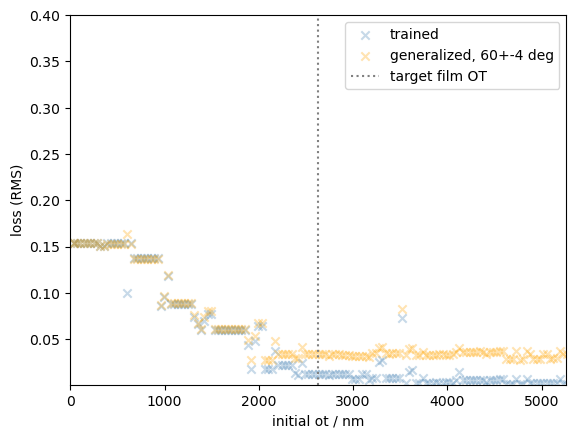

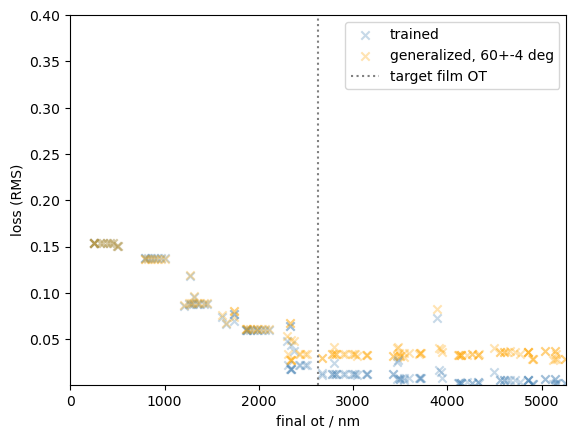

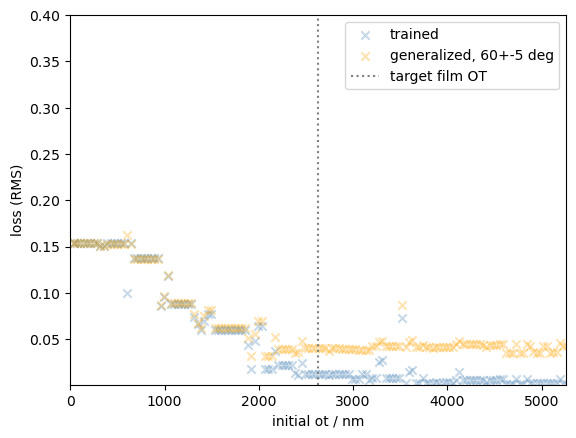

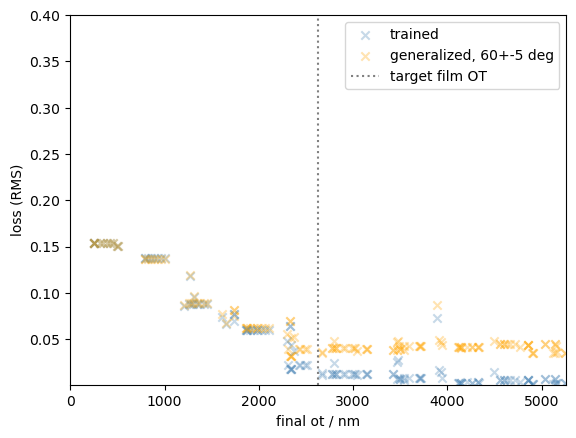

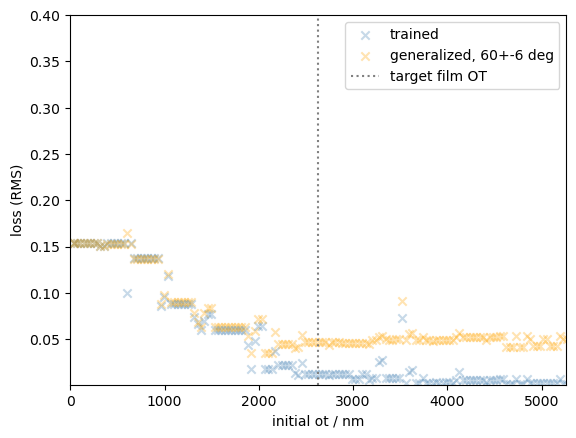

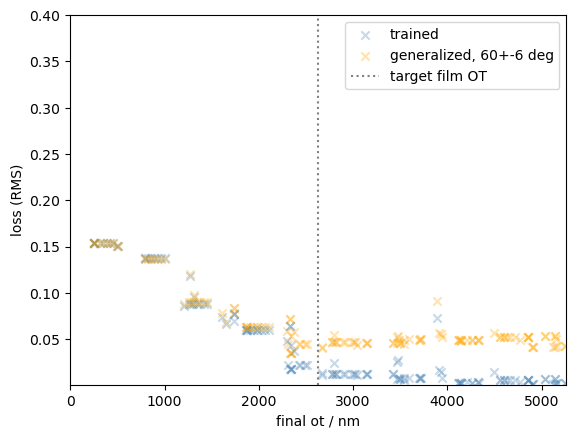

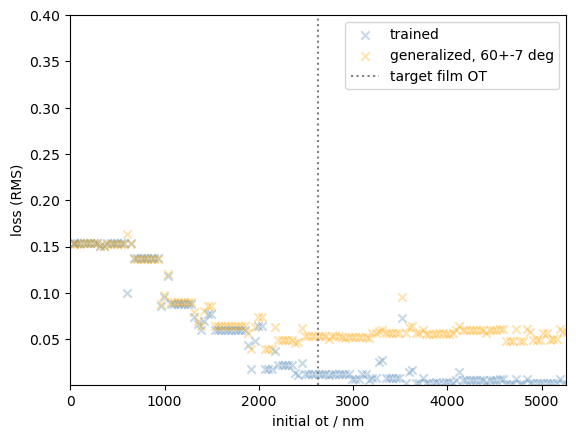

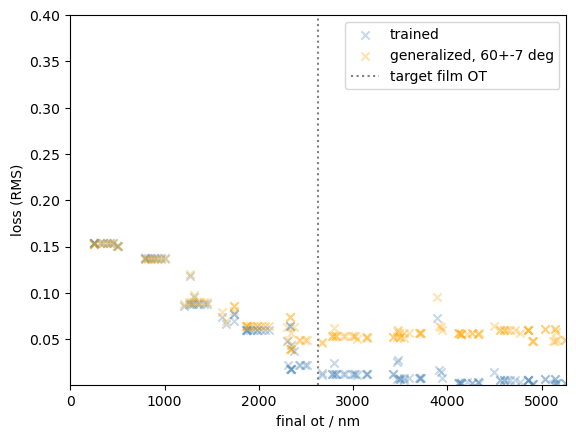

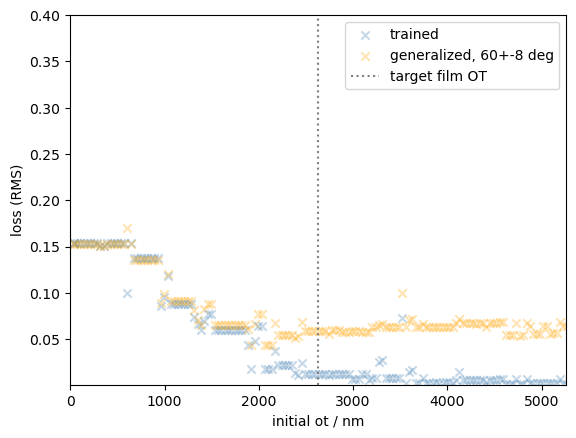

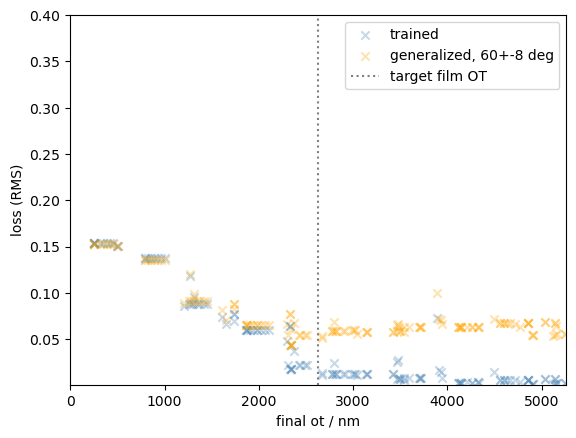

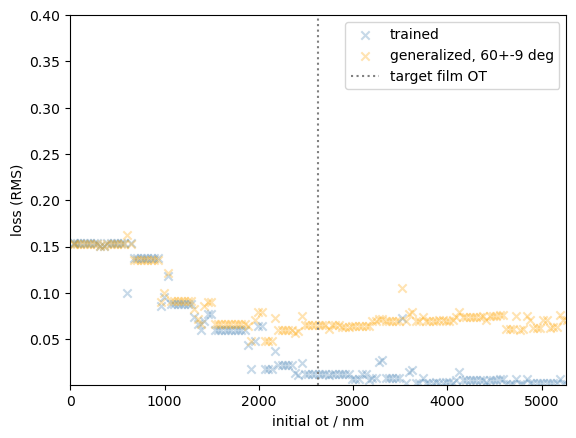

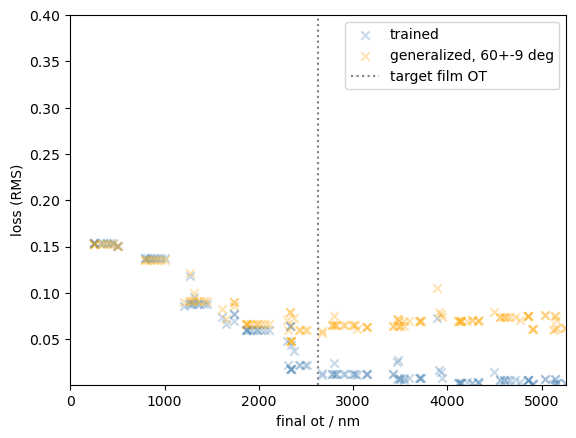

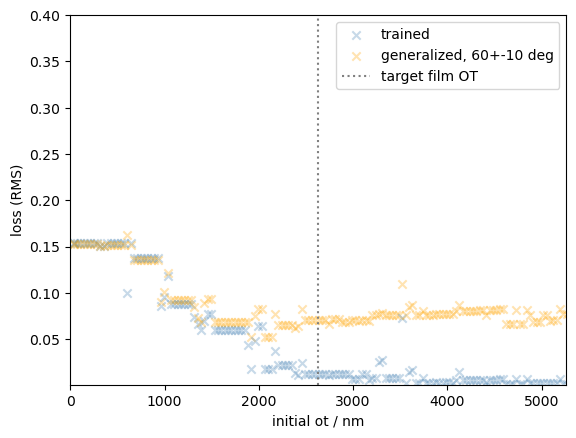

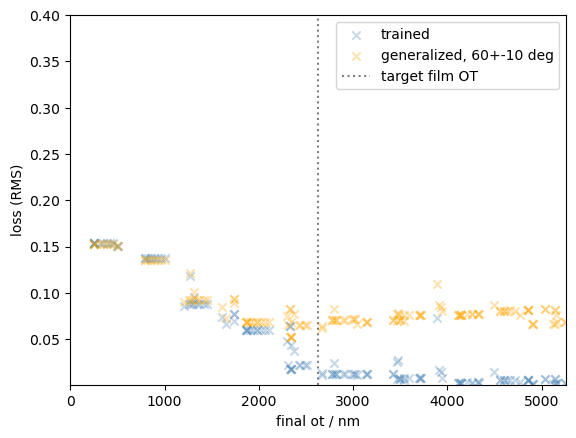

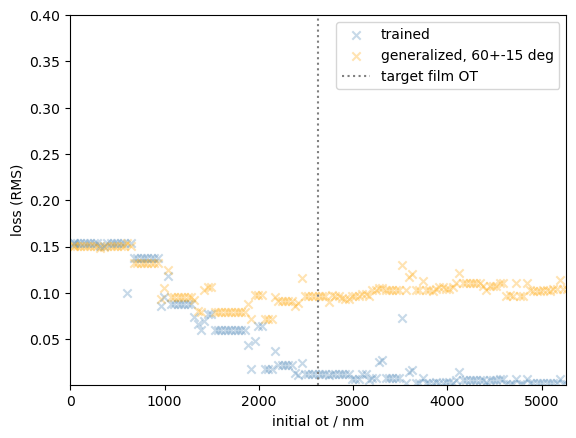

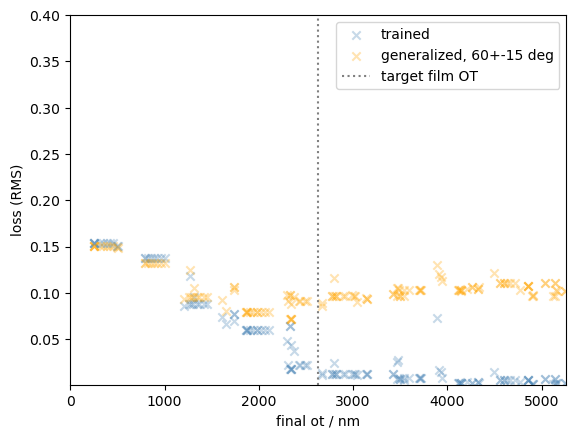

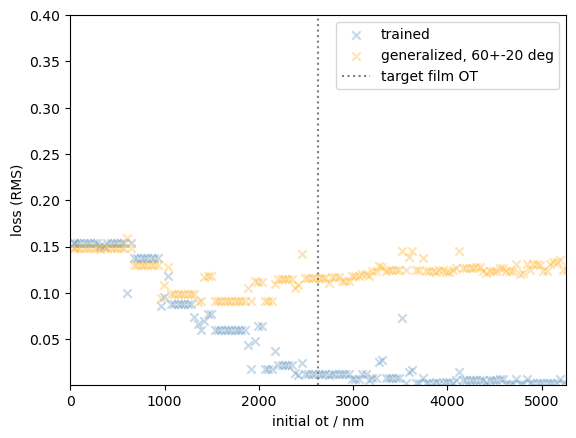

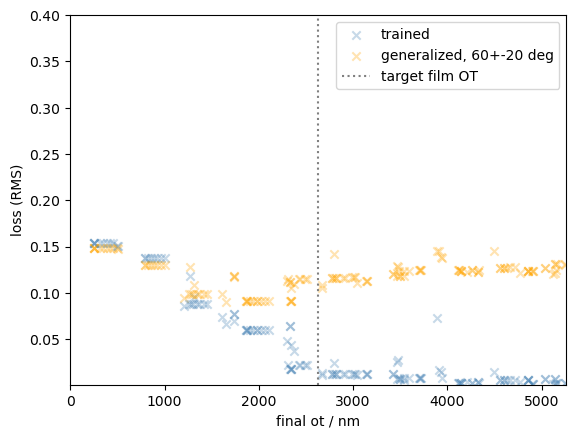

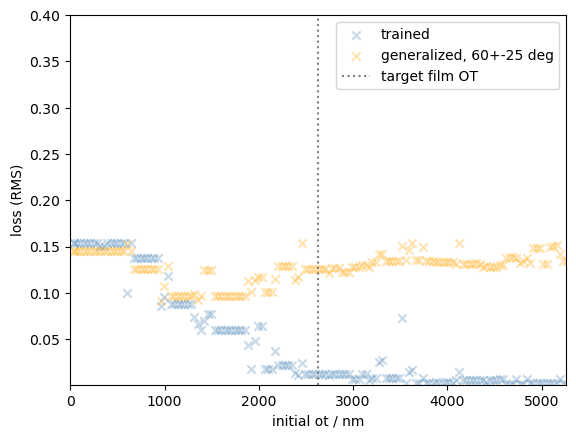

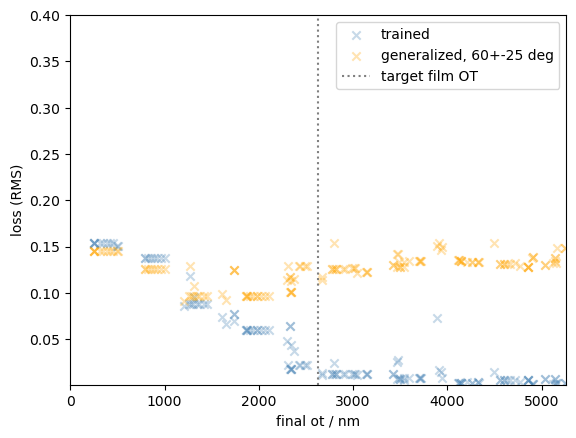

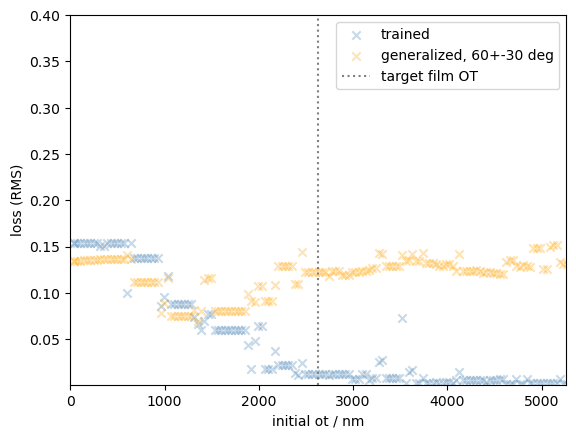

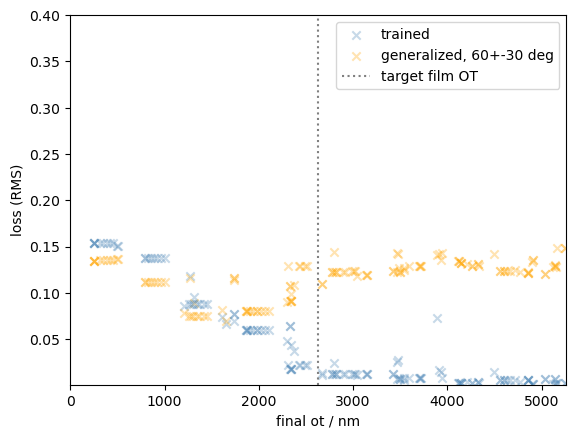

In [4]:
def plot_generalization(designs, file_dir):
    gen_angs_biases = list(range(1, 10)) + list(range(10, 35, 5))
    wl = 750.

    gen_number = len(gen_angs_biases)

    for i, gen_angs_bias in zip(range(gen_number), gen_angs_biases):
        gen_angs = [60. - gen_angs_bias, 60. + gen_angs_bias]

        def generalize(designs: list[DesignSimple]):
            gen_designs = []
            for design in designs:
                gen_design = copy.deepcopy(design)
                for inc_ang in gen_angs:
                    gen_design.target_film.remove_spec_param(INC_ANG, WLS) # remove original one
                    gen_design.target_film.add_spec_param(inc_ang, WLS)
                    
                    gen_design.film.remove_spec_param(INC_ANG, WLS)
                    gen_design.film.add_spec_param(inc_ang, WLS)
                gen_design.calculate_loss()
                gen_designs.append(gen_design)
            return gen_designs

        gen_designs = generalize(designs)

        def plot_final(design_list: list[DesignSimple], gen_designs_list: list[DesignSimple]): # bad variabe naming!
            fig, ax = plt.subplots(1, 1)
            for design, gen_design in zip(design_list, gen_designs_list):
                ax.scatter(design.get_current_ot(wl), design.loss, c='steelblue', marker='x', alpha=0.3)
                ax.scatter(gen_design.get_current_ot(wl), gen_design.loss, c='orange', marker='x', alpha=0.3)

            # scatter the first dot for the legend
            design, gen_design = designs[0], gen_designs[0]
            ax.scatter(design.get_current_ot(wl), design.loss, c='steelblue', marker='x', label='trained', alpha=0.3)
            ax.scatter(gen_design.get_current_ot(wl), gen_design.loss, c='orange', marker='x', label=f'generalized, 60+-{gen_angs_bias} deg', alpha=0.3)

            target_ot = design.get_target_ot(wl)
            ax.plot([target_ot, target_ot], [0, 1], label='target film OT', c='gray', ls=':')
            
            
            ax.legend()
            ax.set_xlabel('final ot / nm')
            ax.set_ylabel('loss (RMS)')
            ax.set_xlim(0, target_ot * 2)
            
            ax.set_yscale('log')
            fig.savefig(file_dir+f"gen_60+-{gen_angs_bias}-wrt_final_ot_log.png", dpi=300)
            
            ax.set_ylim(0, 0.4) # set lower bound of y to zero
            ax.set_yscale('linear')
            fig.savefig(file_dir+f"gen_60+-{gen_angs_bias}-wrt_final_ot.png", dpi=300)
            # plot one loss-init ot figure each iter

        def plot_init(design_list: list[DesignSimple], gen_designs_list: list[DesignSimple]): # bad variabe naming!
            fig, ax = plt.subplots(1, 1)
            for design, gen_design in zip(design_list, gen_designs_list):
                ax.scatter(design.get_init_ot(wl), design.loss, c='steelblue', marker='x', alpha=0.3)
                ax.scatter(gen_design.get_init_ot(wl), gen_design.loss, c='orange', marker='x', alpha=0.3)

            # scatter the first dot for the legend
            design, gen_design = designs[0], gen_designs[0]
            ax.scatter(design.get_init_ot(wl), design.loss, c='steelblue', marker='x', label='trained', alpha=0.3)
            ax.scatter(gen_design.get_init_ot(wl), gen_design.loss, c='orange', marker='x', label=f'generalized, 60+-{gen_angs_bias} deg', alpha=0.3)

            target_ot = design.get_target_ot(wl)
            ax.plot([target_ot, target_ot], [0, 1], label='target film OT', c='gray', ls=':')
            
            
            ax.legend()
            ax.set_xlabel('initial ot / nm')
            ax.set_ylabel('loss (RMS)')
            ax.set_xlim(0, target_ot * 2)
            # ax.set_ylim(0, 0.4) # set lower bound of y to zero
            ax.set_yscale('log')
            fig.savefig(file_dir+f"gen_60+-{gen_angs_bias}-wrt_init_ot_log.png", dpi=300)
            
            ax.set_ylim(0, 0.4) # set lower bound of y to zero
            ax.set_yscale('linear')
            fig.savefig(file_dir+f"gen_60+-{gen_angs_bias}-wrt_init_ot.png", dpi=300)
        
        plot_init(designs, gen_designs)
        plot_final(designs, gen_designs)

for run_name in runs_dict:
    if 'seed' not in run_name:
        continue
    plot_generalization(runs_dict[run_name]['designs'], runs_dict[run_name]['save_fig_dir']) # time: about 4 mins



c:\Users\rfeng6\.conda\envs\TFNN\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rfeng6\.conda\envs\TFNN\lib\site-packages\matplotlib\transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_16216\240107716.py:50: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(None, 1)


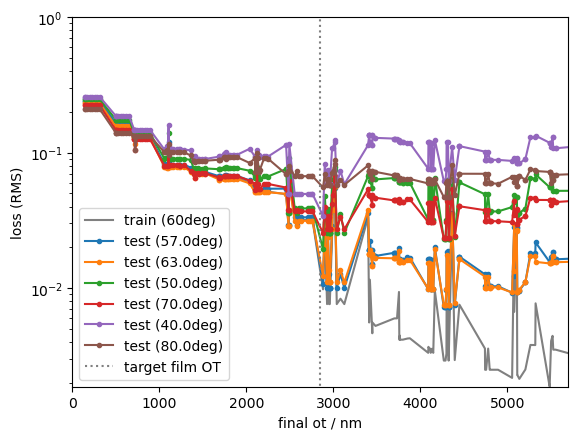

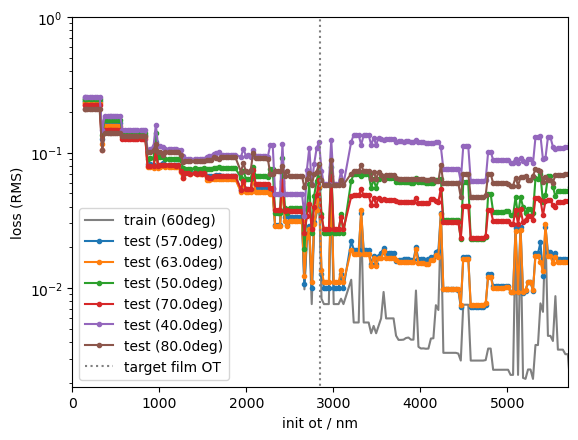

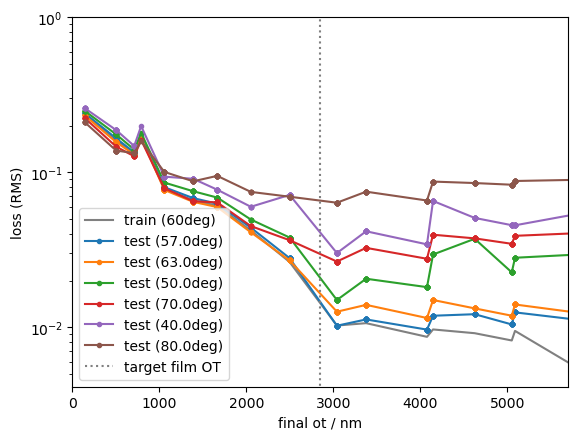

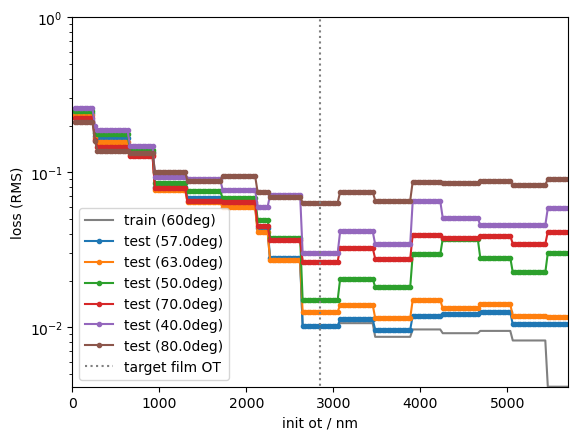

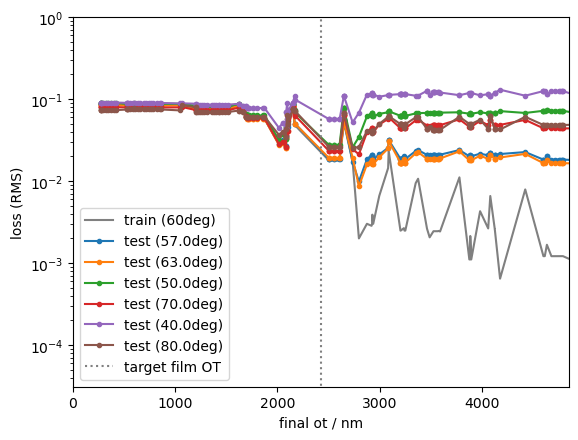

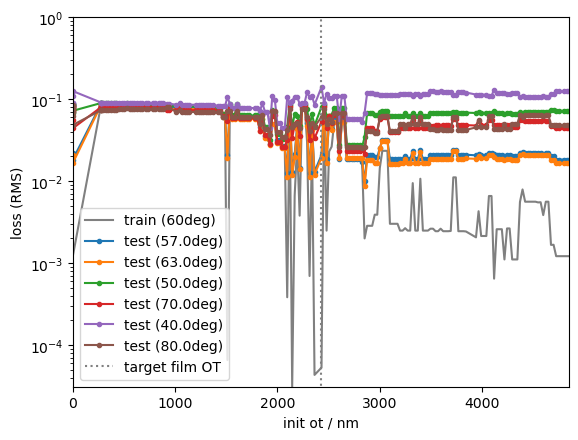

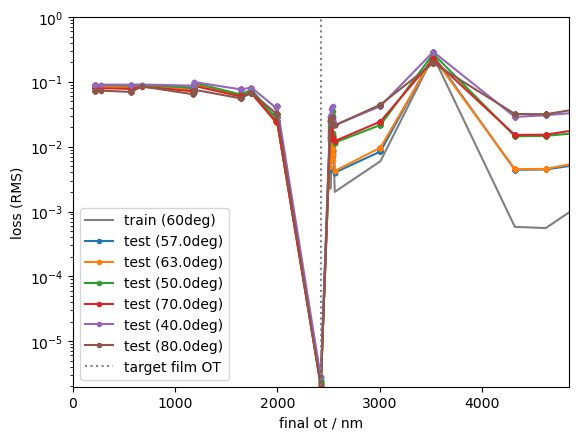

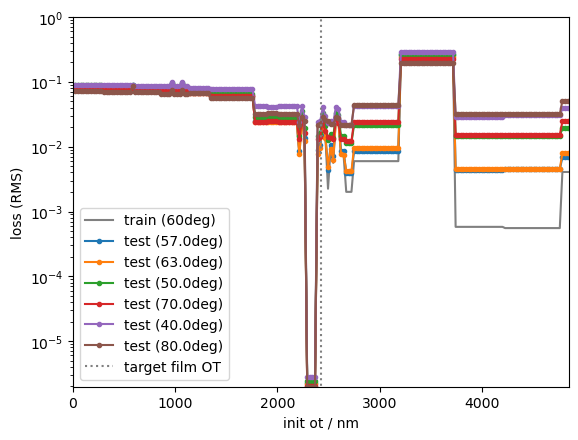

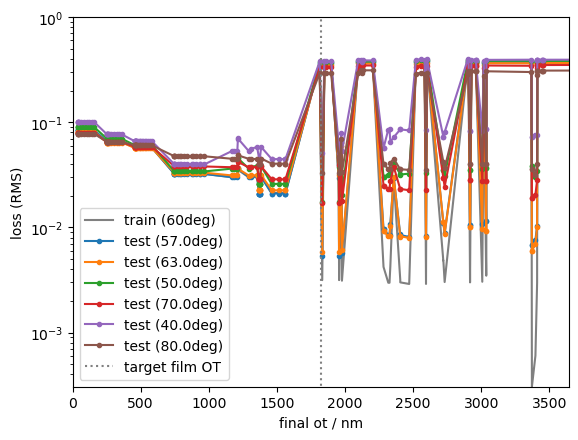

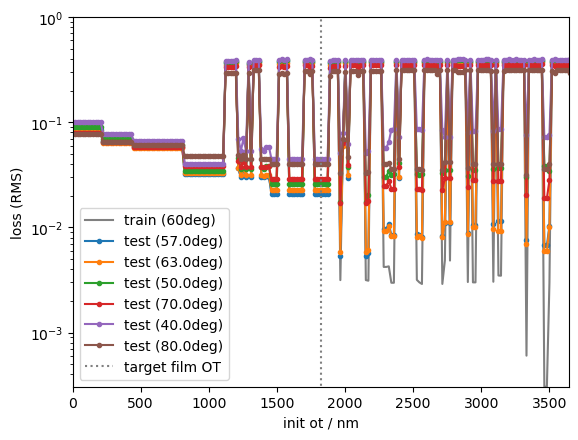

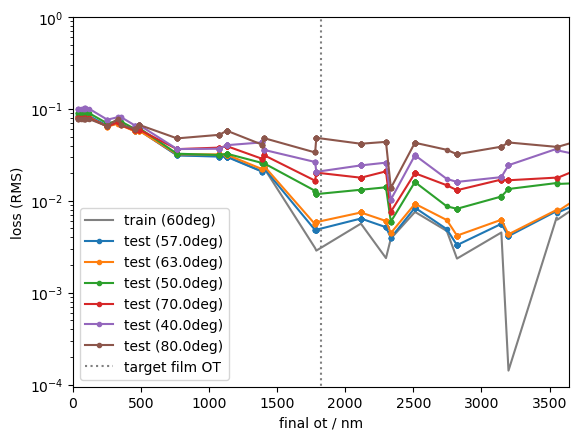

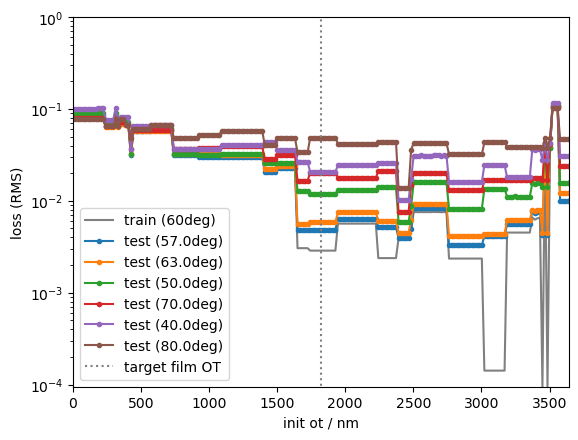

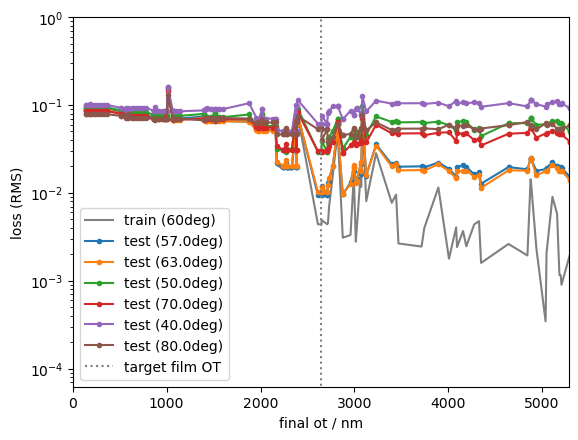

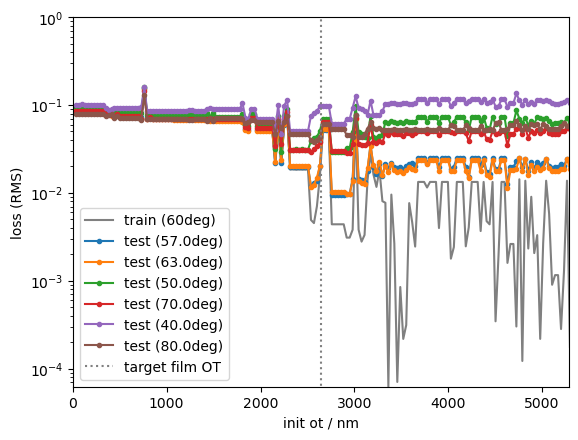

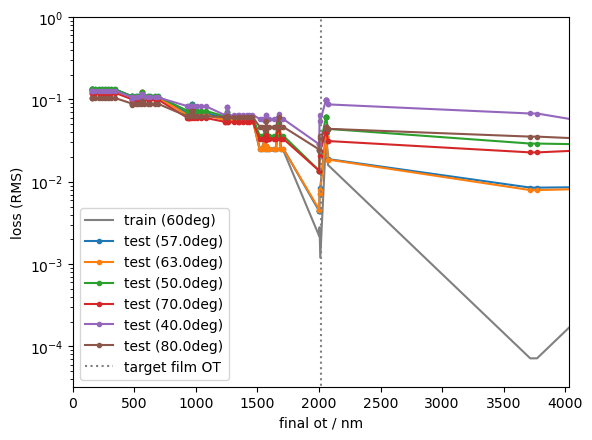

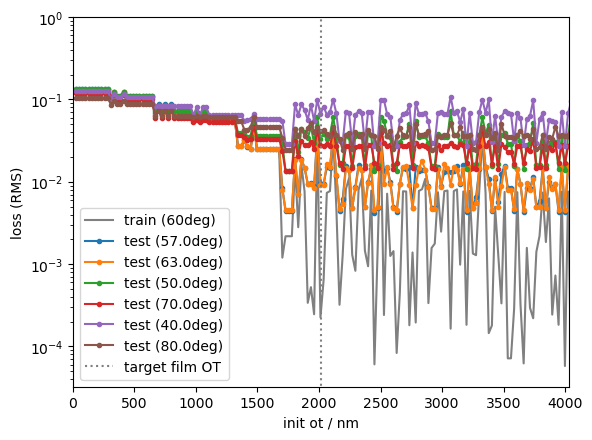

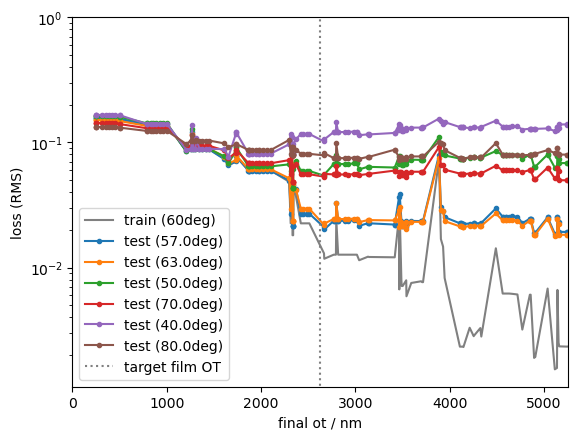

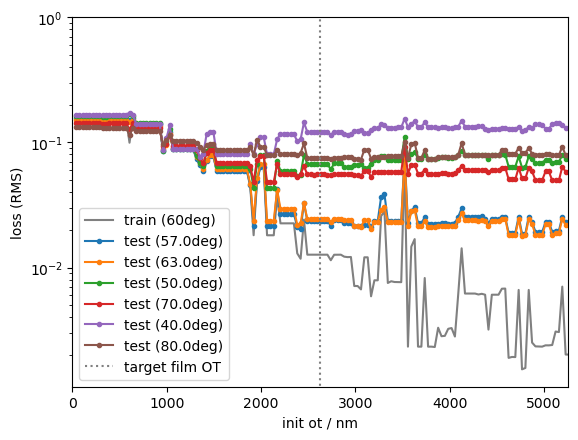

In [5]:
def plot_generalization_in_one(designs: list[DesignSimple], save_fig_dir, x_axis='init'):
    gen_angs_biases = [3, 10, 20]
    wl = 750.

    gen_number = len(gen_angs_biases)


    # sort design against init/final ot
    if x_axis == 'final':
        get_x = lambda x: x.get_current_ot()
    elif x_axis == 'init':
        get_x = lambda x: x.get_init_ot()
    else:
        assert False, 'should not run here'

    designs, _ = sort_by_ith_list(designs, [get_x(design) for design in designs], index=1)

    def generalize(designs: list[DesignSimple], gen_ang):
            gen_loss = []
            for design in designs:
                tmp_design = copy.deepcopy(design)
                tmp_design.target_film.remove_spec_param(INC_ANG, WLS)
                tmp_design.target_film.add_spec_param(gen_ang, WLS)
                tmp_design.film.remove_spec_param(INC_ANG, WLS)
                tmp_design.film.add_spec_param(gen_ang, WLS)
                gen_loss.append(tmp_design.calculate_loss())
            return gen_loss
    
    # plot figure: boefore generalize
    fig, ax = plt.subplots(1, 1)
    x = [get_x(design) for design in designs]
    original_loss = [design.calculate_loss() for design in designs]
    ax.plot(x, original_loss, label='train (60deg)', ls='-', color='grey')

    for gen_ang in [ang for gen_angs_bias in gen_angs_biases for ang in [60. - gen_angs_bias, 60. + gen_angs_bias]]:
        gen_loss = generalize(designs, gen_ang)
        ax.plot(x, gen_loss, label=f'test ({gen_ang}deg)', ls='-', marker='.')

    target_ot = designs[0].get_target_ot(wl)
    ax.plot([target_ot, target_ot], [0, 1], label='target film OT', c='gray', ls=':')
    ax.legend()
    ax.set_xlabel(f'{x_axis} ot / nm')
    ax.set_ylabel('loss (RMS)')
    ax.set_xlim(0, target_ot * 2)
    ax.set_ylim(0, 0.4) # set lower bound of y to zero
    ax.set_yscale('linear')
    fig.savefig(save_fig_dir + f'gen_loss-{x_axis}_ot.png', dpi=300)
  
    ax.set_yscale('log')
    ax.set_ylim(None, 1)
    fig.savefig(save_fig_dir + f'gen_loss-{x_axis}_ot_log.png', dpi=300)

for run_name in runs_dict:
    if 'seed' not in run_name:
        continue
    plot_generalization_in_one(runs_dict[run_name]['designs'], runs_dict[run_name]['save_fig_dir'], 'final')
    plot_generalization_in_one(runs_dict[run_name]['designs'], runs_dict[run_name]['save_fig_dir'], 'init')
 

In [13]:
# find suspicious run
i = 0
for design in runs_dict['TiO2_4layers']['designs']:
    i += 1
    if design.calculate_loss() < 1e-4:
        print(i)

90
91
92
93
